# PROYECTO FINAL

La empresa GoGreen Bikesharing se dedica al alquiler de bicicletas y posee datos tales como la cantidad de bicis alquiladas por usuarios registrados, la cantidad de alquileres realizados por usuarios puntuales, y la cantidad total. 

A estos datos se les añadió información meteorológica y el calendario de festivos.

Ahora buscan analizar cuáles son los aspectos que más influyen en la cantidad de bicis que van a alquilar en un día.

In [178]:
# Tratamiento de datos
import numpy as np
import pandas as pd
#import sidetable as stb

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import sidetable as stb

# Asunciones y Preprocesamiento
from scipy import stats
import math
from scipy.stats import levene
#import researchpy as rp
from sklearn.preprocessing import StandardScaler
import itertools
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
import researchpy as rp # chi square

#Linear Regresion con Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = False

In [179]:
df_bike = pd.read_csv("./EDA__parte_3.csv", index_col=0)
df_bike.sample(6)

,casual,registered,cnt,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,temp_interval,temp_interval_ord,hum,hum_interval,hum_interval_ord,windspeed,wind_interval,wind_num_encoding
582,1233,5780,7013,2,1,8,6,0,1,1,2,30.9,very_high,5,65.4,high,4,8.666718,low,1
629,2512,5883,8395,3,1,9,22,0,6,0,1,26.6,high,4,64.7,high,4,19.000061,medium,2
380,217,2081,2298,1,1,1,16,1,1,0,1,7.8,very_low,1,52.2,medium,3,15.500986,medium,2
686,922,3747,4669,4,1,11,18,0,0,0,1,14.0,low,2,69.3,high,4,15.250004,medium,2
440,3155,4681,7836,1,1,3,17,0,6,0,2,21.1,medium,3,75.6,high,4,7.417168,very_low,very_low
44,208,1705,1913,1,0,2,14,0,1,1,1,17.0,medium,3,37.6,low,2,27.999836,very_high,very_high


---------

# <font color = orange> REGRESIÓN LINEAL MULTIPLE

### Este DF por ahora debe contener nuestra variable respuesta y todas las variables predictivas.

- Vamos a ver la variable respuesta grafico y comprobar la normalidad = 'cnt'
- Vamos a ver graficos de variables predictivas
- Correlacion
- Covarianza
- Vamos a ver si cumplen las asunciones para hacer Anova



### Puede haber 2 opciones:
1. cnt + todas encoding
2. cnt + encoding + numericas(que habrá que estandarizar antes de meter en el modelo de regresion)

###  <font color = yellow> Opcion 2

cnt + encoding + numericas(que habrá que estandarizar antes de meter en el modelo de regresion)

    Este dataframe tiene variable respuesta, y las predictoras encoding como tipo objets y numericas que sin encoding.

In [180]:
df= df_bike.copy() # Voy a hacer una copia para no perder los datos por si necesita hacer OPCION 1

In [181]:
df.drop(['casual', 'registered','temp_interval', 'temp_interval_ord','hum_interval','hum_interval_ord', 'wind_interval', 'wind_num_encoding'],axis=1, inplace=True)
    

In [182]:
df.head()

,cnt,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,985,1,0,1,1,0,6,0,2,14.1,80.6,10.749882
1,801,1,0,1,2,0,0,0,2,14.9,69.6,16.652113
2,1349,1,0,1,3,0,1,1,1,8.1,43.7,16.636703
3,1562,2,0,1,4,0,2,1,1,8.2,59.0,10.739832
4,1600,2,0,1,5,0,3,1,1,9.3,43.7,12.522300


In [183]:
df.info() #Correcto tenemos que volver a cambiar el tipo de cada columna 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cnt              730 non-null    int64  
 1   season_encoding  730 non-null    int64  
 2   yr               730 non-null    int64  
 3   mnth             730 non-null    int64  
 4   day              730 non-null    int64  
 5   holiday          730 non-null    int64  
 6   weekday          730 non-null    int64  
 7   workingday       730 non-null    int64  
 8   weathersit       730 non-null    int64  
 9   temp             730 non-null    float64
 10  hum              730 non-null    float64
 11  windspeed        730 non-null    float64
dtypes: float64(3), int64(9)
memory usage: 74.1 KB


In [184]:
df.columns

Index(['cnt', 'season_encoding', 'yr', 'mnth', 'day', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'hum', 'windspeed'],
      dtype='object')

In [185]:
df['season_encoding'] = df['season_encoding'].astype('object')  
df['yr'] = df['yr'].astype('object')  
df['mnth'] = df['mnth'].astype('object')  
df['day'] = df['day'].astype('object')  
df['holiday'] = df['holiday'].astype('object')  
df['weekday'] = df['weekday'].astype('object')  
df['workingday'] = df['workingday'].astype('object')  
df['weathersit'] = df['weathersit'].astype('object')  

### Variable respuesta - NORMALIDAD - SHAPIRO

    Nuestra variable respuesta es 'cnt', queremos ver cuantas reservas general según las variables predictoras.
    Parece que tenemos una distribución normal de nuestros datos.

ShapiroResult(statistic=0.9802490472793579, pvalue=2.313480784721378e-08)


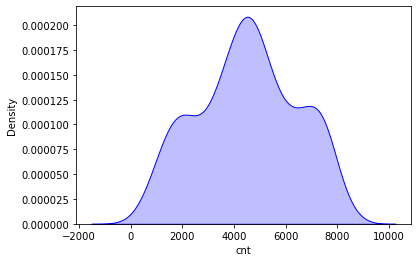

In [186]:
sns.distplot(
    df_bike.cnt, 
    hist = False, 
    color = "blue", 
    kde_kws = {"shade": True, "linewidth": 1});

print(stats.shapiro(df_bike["cnt"])) # EL p-value< 0.05 Quiere decir que la distribución es normal

### Variables predictoras CATEGORICAS - GRAFICO

    Estas son nuestras variables categoricas

In [187]:
categoricas = df_bike.select_dtypes(include='object')
categoricas.head(1)

,temp_interval,hum_interval,wind_interval,wind_num_encoding
0,low,very_high,low,1


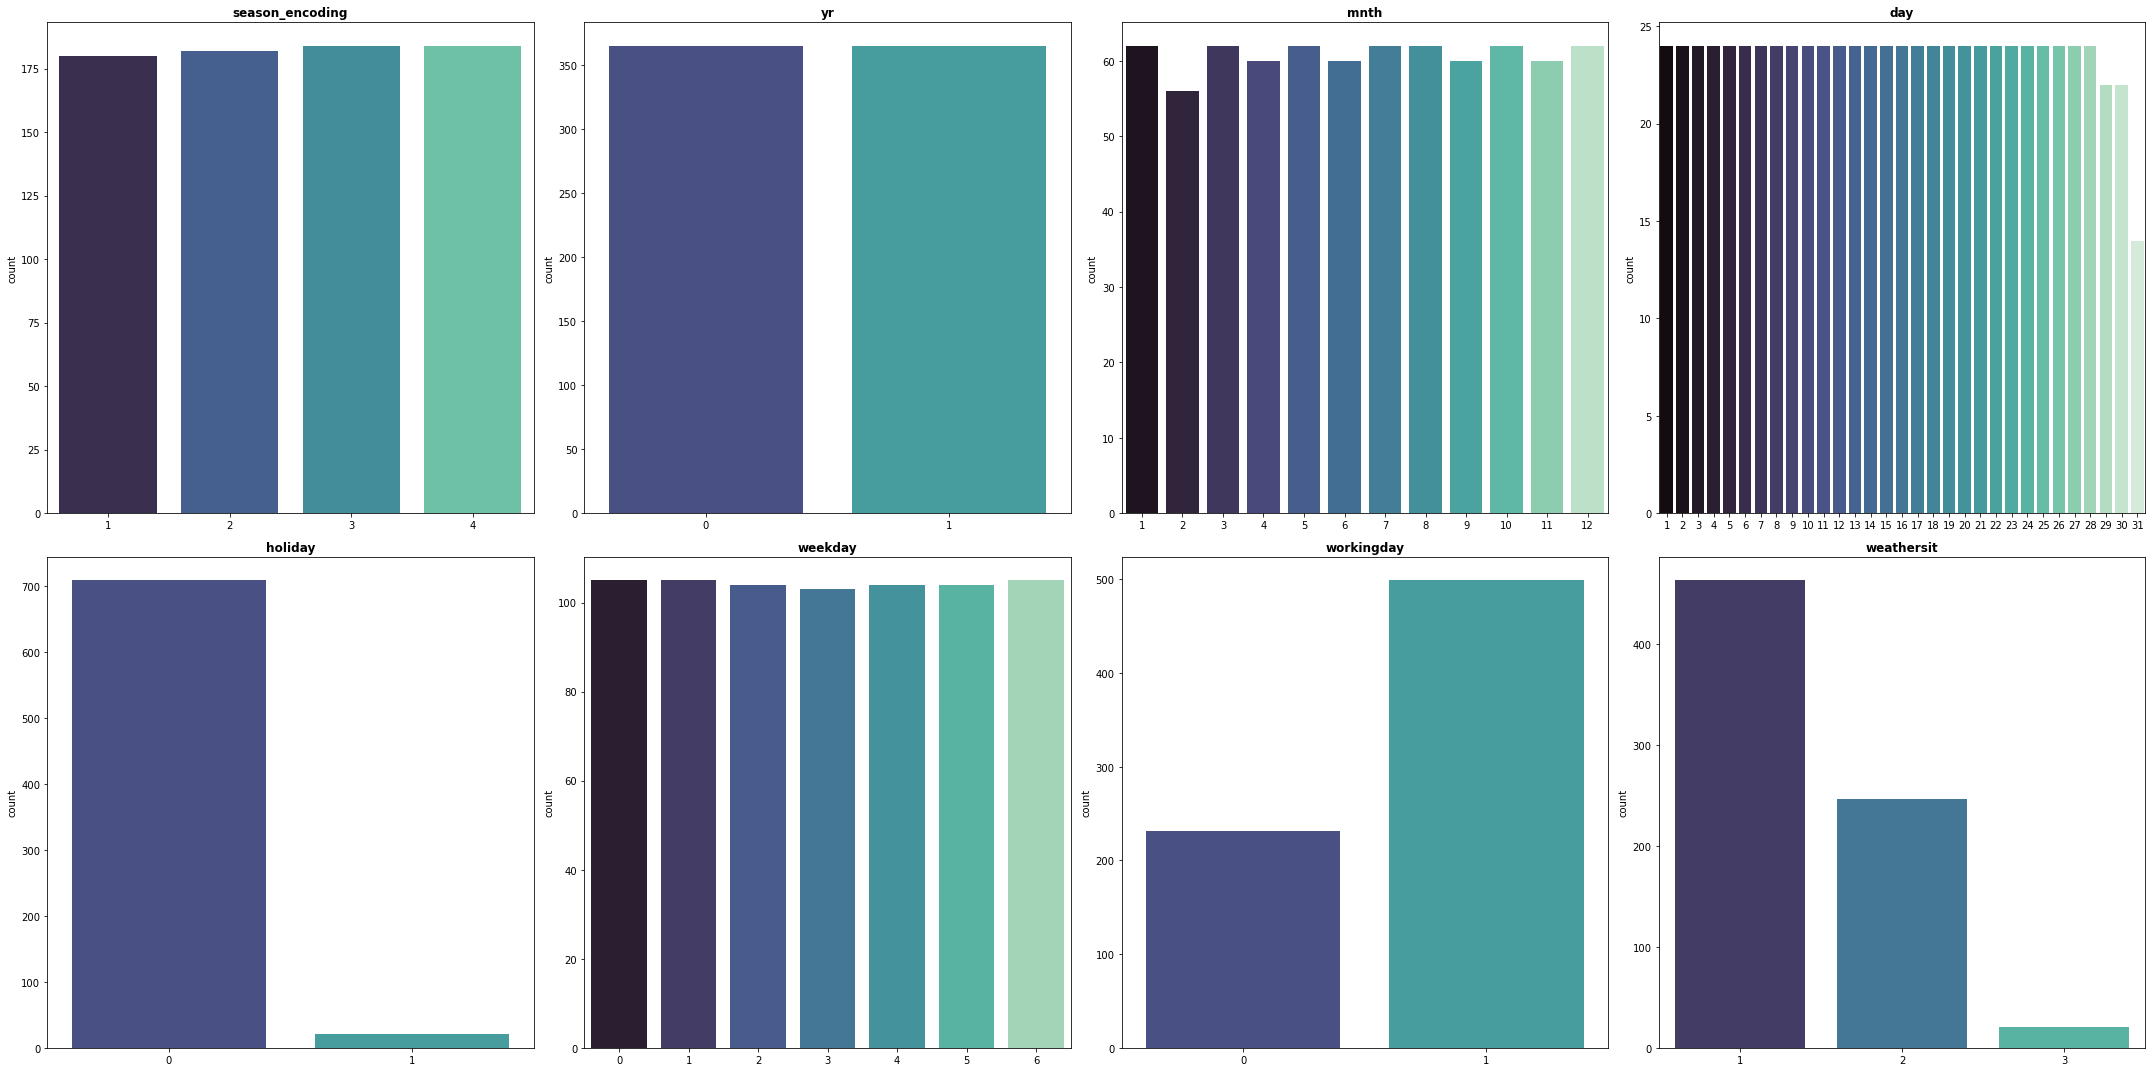

In [188]:
# Gráfico de relación entre variables predictoras y la variable a predecir CATEGORICAS
# ===================================================================================

fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (30, 15))

axes = axes.flat

columnas_object = df.select_dtypes(include = "object").columns

for i, colum in enumerate(columnas_object):
    sns.countplot(df[colum], ax=axes[i], palette="mako")
    axes[i].set_title(colum, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")
    
fig.tight_layout();



### Variables predictoras NUMERICAS - GRAFICO

    Estas son nuestras variables numéricas

In [189]:
numericas = df.select_dtypes(include = np.number)
numericas.head(1)

,cnt,temp,hum,windspeed
0,985,14.1,80.6,10.749882


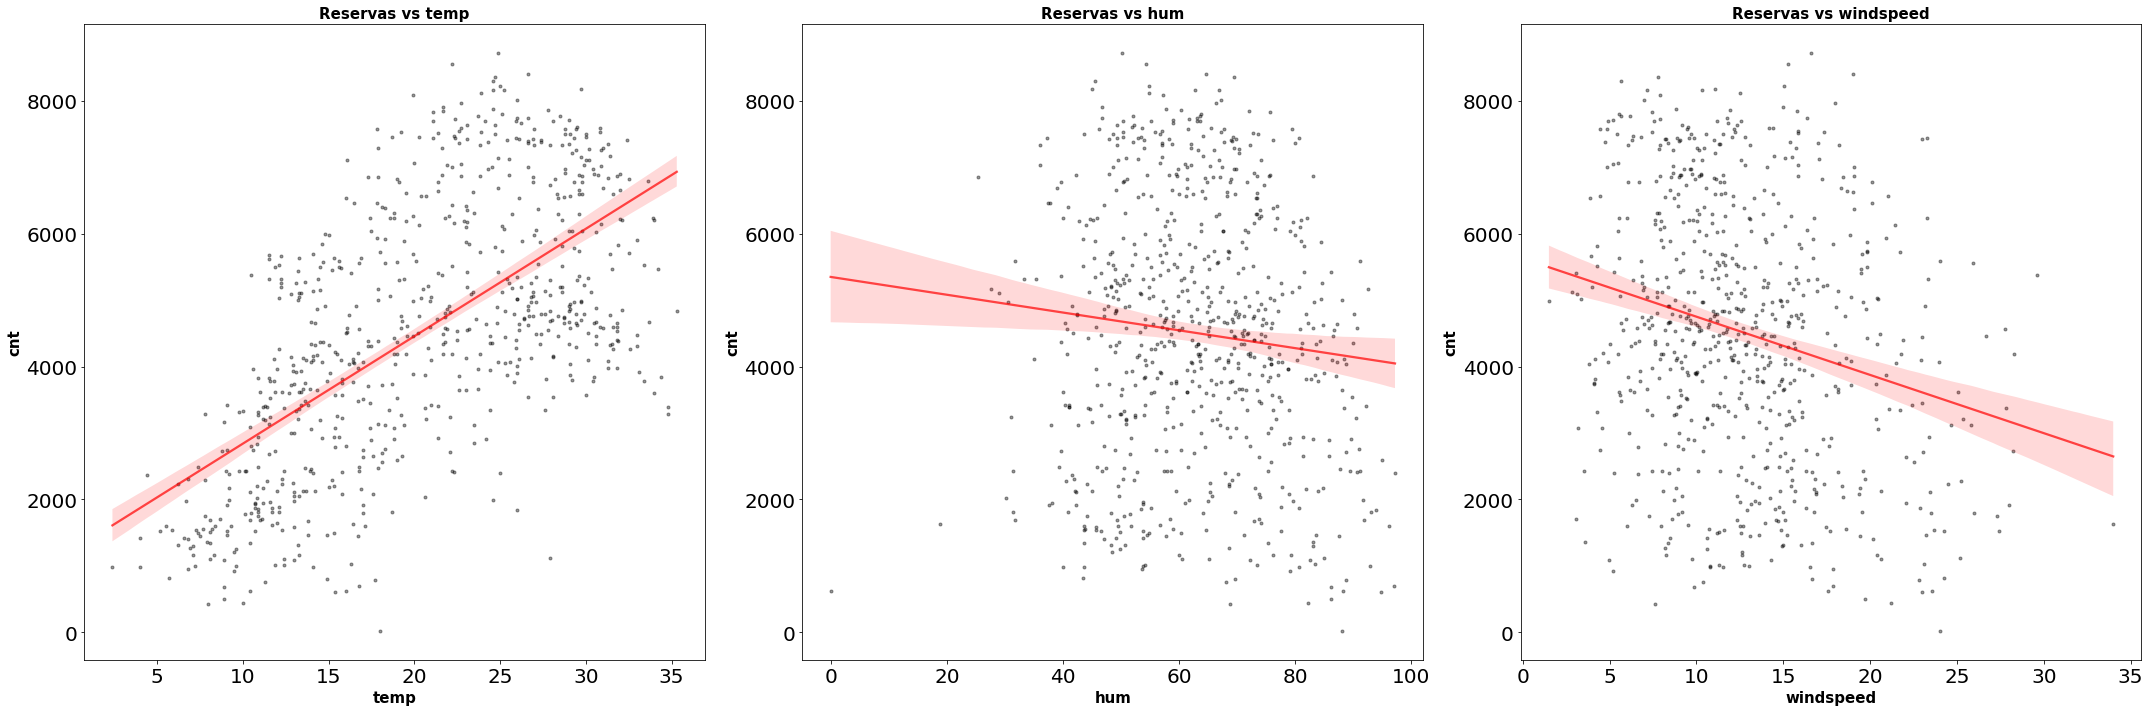

In [190]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))

axes = axes.flat

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("cnt") # excluimos nuestra variable respuesta. (No la necesitamos ahora

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum], 
        y = df["cnt"], 
        color = "black", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Reservas vs {colum}", fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel(colum,  fontsize = 15, fontweight = "bold")
    axes[i].set_ylabel("cnt", fontsize = 15, fontweight = "bold")
    
fig.tight_layout();

### Vamos a comprobar la relación que hay entre numericas

In [191]:
numericas2 = df.select_dtypes(include = np.number).drop("cnt", axis = 1)

    COVARIANZA
    ¿Ambas variables aumentan o disminuyen en la misma dirección o cuando una aumenta la otra disminuye?
        S> 0 COVARIANZA POSITIVA : Todos aumentan misma dirección ( a grandes valores de X, grandes valores de Y)
        S = 0 NO HAY RELACIÓN LINEAL
        S< 0 COVARIANZA NEGATIVA: Aumenta una y disminuye la otra (a grandes valores de X , pequeños valores de Y)

In [192]:
numericas2.cov() # vamos a ver si existe colinealidad entre mas medias de las variables predictoras

,temp,hum,windspeed
temp,56.350559,13.757125,-6.176868
hum,13.757125,202.717828,-18.389602
windspeed,-6.176868,-18.389602,26.996761


    CORRELACIÓN
        Vamos a ver la correlación entre las variables predictoras y que relación tienen tb con la respuesta.
        intervalo [-1 y 1]
	    r= 1 corr perfecta positiva (aumenta una , la otra tb aumenta)
	    r =0 no hay correlación
 	    r= -1 corr perfecta negativa (una aumenta y la otra disminuye)

In [193]:
numericas.corr()  # Pearson Correlation Coefficient

,cnt,temp,hum,windspeed
cnt,1.000000,0.627003,-0.098502,-0.235132
temp,0.627003,1.000000,0.128716,-0.158367
hum,-0.098502,0.128716,1.000000,-0.248582
windspeed,-0.235132,-0.158367,-0.248582,1.000000


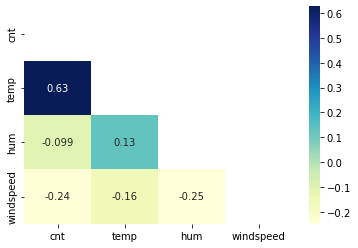

In [194]:
mask = np.triu(np.ones_like(numericas.corr(), dtype = np.bool))
sns.heatmap(numericas.corr(), 
           cmap = "YlGnBu", 
           annot = True, 
           mask =mask);


In [195]:
def detectar_outliers(lista_columnas, dataframe): 
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    return dicc_indices 

In [196]:
lista_columnas = list(numericas.columns)
lista_columnas

['cnt', 'temp', 'hum', 'windspeed']

     Son pocos Outliers que no influyen en demasiado lo cambiamos por la mediana

In [197]:
ind = detectar_outliers(lista_columnas, df)
print(ind)

{'hum': [49, 68], 'windspeed': [44, 49, 93, 94, 292, 382, 407, 420, 431, 432, 449, 665, 720]}


In [198]:
for k, v in ind.items():
    mediana = df[k].median() 
    for i in v: 
        df.loc[i,k] = mediana

# Comprobación de las asunciones - Las variables predictoras deben cumplir: Homocedasteidad, Independencia 

### ASUNCIÓN DE NORMALIDAD  

    Ya la hemos comprobado y nuestros datos son normales.

- Visualmente
- Test de Shapiro


| Test Shapiro  |  Resultado | Conclusión |
|---|---|---|
|  p-value > 0.05 | No significativo   | Datos  Normales|
|p-value < 0.05| Significativo| Datos No Normales |

In [199]:
stats.shapiro(df["cnt"]) # El p-value< 0.05 Quiere decir que la distribución es normal

ShapiroResult(statistic=0.9802490472793579, pvalue=2.313480784721378e-08)

### ASUNCIÓN DE HOMOCEDASTICIDAD (Levene)

Las varianzas no difieren entre las distintas categorías de nuestros datos


| Test Levene  |  Resultado | Conclusión   |
|---|---|---|
|  p-value > 0.05 | No significativo   | Cumple asunción, tienen varianzas similares|
|p-value < 0.05| Significativo| No cumple asunción, no tienen varianzas similares |

    - Variables Categoricas -

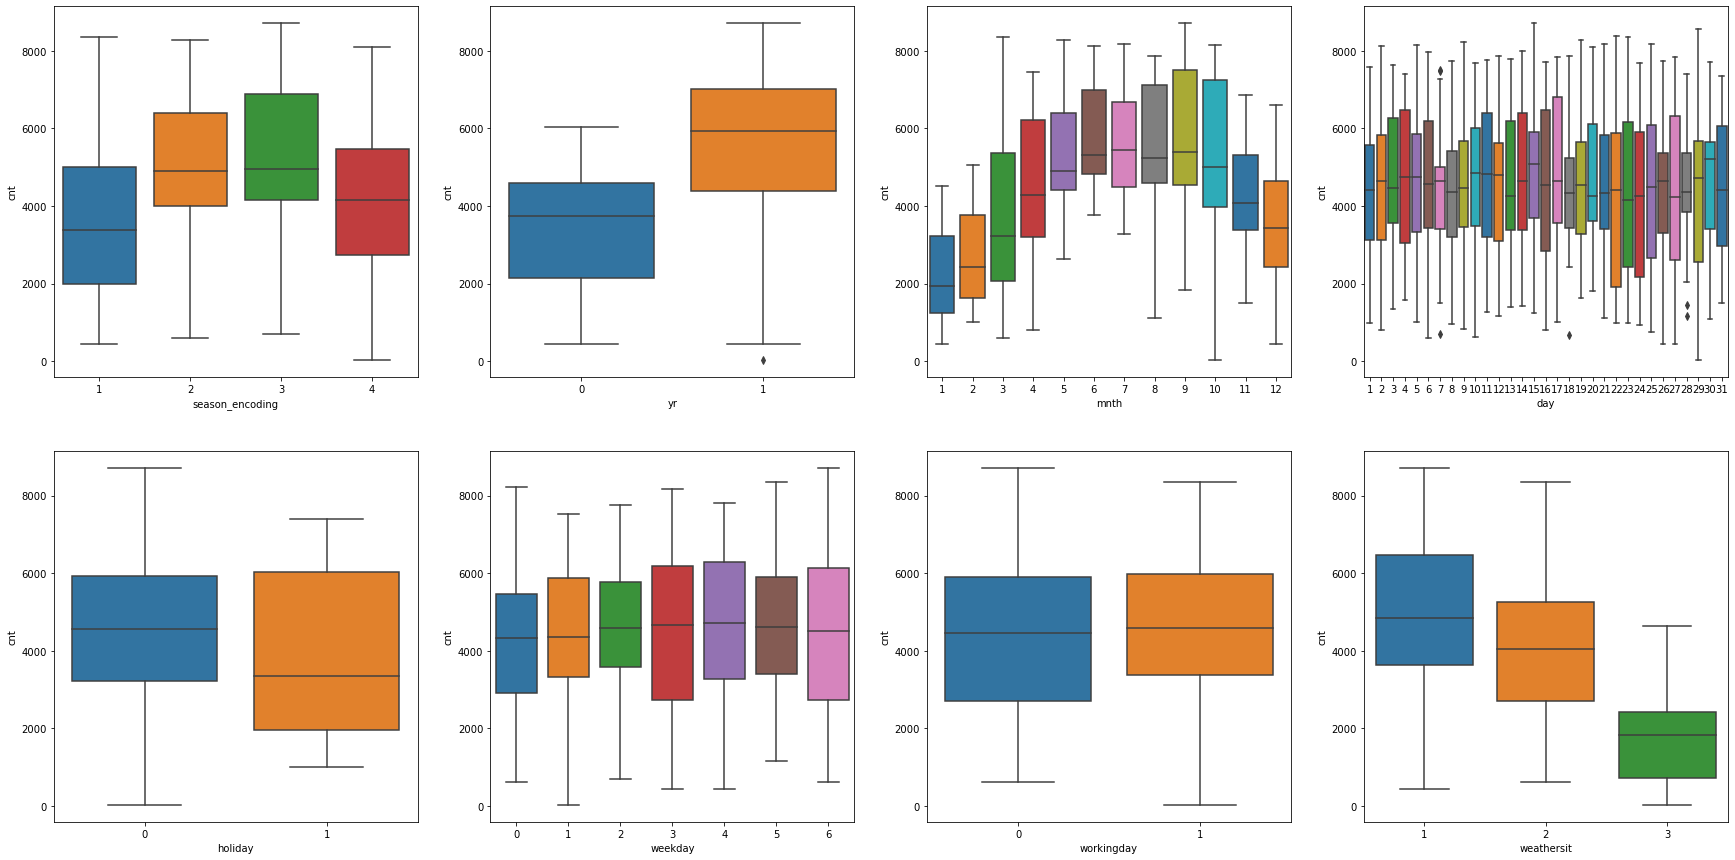

In [200]:
fig, axes = plt.subplots(nrows = 2, ncols = 4 ,figsize = (30, 15))

axes = axes.flat

colum_cat = df.select_dtypes(include = ['object']).columns

for i, col in enumerate(colum_cat):
    sns.boxplot(
        x = col,
        y = 'cnt',
        data = df,
        palette = 'tab10',
        ax = axes[i]

    )

                                                        --TEST LEVENE PARA CADA VARIABLE CATEGORICA PREDICTORA--

In [201]:
#Para desglosar cada una de las columnas, hacemos test de levene a cada una
def datos_test_levene (columna, df):
    valores = df[columna].unique()
    d = {}

    for x in valores:
        d['{0}'.format(x)] = df[df[columna] == x]['cnt']
    return d

In [203]:
# 8 variables categoricas predictoras
season = datos_test_levene('season_encoding', df)
year = datos_test_levene('yr', df)
month = sexo = datos_test_levene('mnth', df)
day = sexo = datos_test_levene('day', df)
holiday = sexo = datos_test_levene('holiday', df)
weekday = sexo = datos_test_levene('weekday', df)
workingday = sexo = datos_test_levene('workingday', df)
weathersit = sexo = datos_test_levene('weathersit', df)

                                                                        --NO CUMPLEN : "YEAR" , "MONTH" , "WORKINGDAY"--

In [206]:
levene_temp_interval = stats.levene(year['0'], year['1'], center='median')
levene_temp_interval # NO CUMPLE

LeveneResult(statistic=13.553593496753745, pvalue=0.0002489869491449798)

In [208]:
levene_temp_interval = stats.levene(month['1'], month['2'],month['3'],month['4'],month['5'],month['6'],month['1'],month['7'],month['1'],month['8'],month['9'],month['10'],month['11'],month['12'], center='median')
levene_temp_interval # NO CUMPLE

LeveneResult(statistic=5.787944098760116, pvalue=2.73789175494516e-10)

In [214]:
levene_temp_interval = stats.levene(workingday['0'], workingday['1'], center='median')
levene_temp_interval # NO CUMPLE

LeveneResult(statistic=4.460702577469021, pvalue=0.03502326959654844)

                                                         --SI CUMPLEN : "SEASON", "DAY", "HOLIDAY" , "WEEKDAY" , "WEATHERSIT"--

In [205]:
levene_season = stats.levene(season['1'], season['2'], season['3'], season['4'], center='median')
levene_season # SI CUMPLE

LeveneResult(statistic=1.7590626071065214, pvalue=0.15360584747469838)

In [209]:
levene_temp_interval = stats.levene(day['1'], day['2'],day['3'],day['4'],day['5'],day['6'],day['1'],day['7'],day['1'],day['8'],day['9'],day['10'],day['11'],day['12'],
 day['13'], day['14'],day['15'],day['16'],day['17'],day['18'],day['19'],day['20'],day['21'],day['22'],day['23'],day['24'],day['25'],day['26'],
 day['27'], day['28'],day['29'],day['30'],day['31'],center='median')
levene_temp_interval # SI CUMPLE

LeveneResult(statistic=0.5456780499569595, pvalue=0.9815493458112784)

In [210]:
levene_temp_interval = stats.levene(holiday['0'], holiday['1'], center='median')
levene_temp_interval # SI CUMPLE

LeveneResult(statistic=0.7261499110317795, pvalue=0.39441424379573353)

In [213]:
levene_temp_interval = stats.levene(weekday['0'], weekday['1'],weekday['2'],weekday['3'],weekday['4'],weekday['5'],weekday['6'], center='median')
levene_temp_interval # SI CUMPLE

LeveneResult(statistic=1.496581827336433, pvalue=0.17647662349169893)

In [215]:
levene_temp_interval = stats.levene(weathersit['1'], weathersit['2'], weathersit['3'],center='median')
levene_temp_interval # SI CUMPLE

LeveneResult(statistic=2.981948873358019, pvalue=0.05131438057388725)

    Numéricas

In [218]:

# creamos un diccionario para almacenar los resultados de los test
resultados = {}

# seleccionamos solo las columnas numéricas y eliminamos la columna de precio
numericas_col = df.select_dtypes(include = np.number).drop("cnt", axis = 1).columns

#iteremos por la lista de las columnas numéricas
for col in numericas_col:
    # calculamos el p-valor de test
    statistic, p_val = levene(df[col], df.cnt, center='median')
    # lo almacenamos en el charges
    resultados[col] = p_val

                    --  SI CUMPLEN TODAS --

In [219]:
resultados 

{'temp': 2.483823693494982e-220,
 'hum': 2.4852444623529654e-219,
 'windspeed': 6.996761844872213e-221}

## Asunción independencia (Chi-Cuadrado)


| Test Independencia |  Resultado | Conclusión   |
|---|---|---|
|  p-value > 0.05 | No significativo   | Cumple asunción, tienen varianzas similares|
|p-value < 0.05| Significativo| No cumple asunción, no tienen varianzas similares |

In [222]:
columnas = df.columns

In [223]:
combinaciones = list(itertools.combinations(columnas, 2))
combinaciones

[('cnt', 'season_encoding'),
 ('cnt', 'yr'),
 ('cnt', 'mnth'),
 ('cnt', 'day'),
 ('cnt', 'holiday'),
 ('cnt', 'weekday'),
 ('cnt', 'workingday'),
 ('cnt', 'weathersit'),
 ('cnt', 'temp'),
 ('cnt', 'hum'),
 ('cnt', 'windspeed'),
 ('season_encoding', 'yr'),
 ('season_encoding', 'mnth'),
 ('season_encoding', 'day'),
 ('season_encoding', 'holiday'),
 ('season_encoding', 'weekday'),
 ('season_encoding', 'workingday'),
 ('season_encoding', 'weathersit'),
 ('season_encoding', 'temp'),
 ('season_encoding', 'hum'),
 ('season_encoding', 'windspeed'),
 ('yr', 'mnth'),
 ('yr', 'day'),
 ('yr', 'holiday'),
 ('yr', 'weekday'),
 ('yr', 'workingday'),
 ('yr', 'weathersit'),
 ('yr', 'temp'),
 ('yr', 'hum'),
 ('yr', 'windspeed'),
 ('mnth', 'day'),
 ('mnth', 'holiday'),
 ('mnth', 'weekday'),
 ('mnth', 'workingday'),
 ('mnth', 'weathersit'),
 ('mnth', 'temp'),
 ('mnth', 'hum'),
 ('mnth', 'windspeed'),
 ('day', 'holiday'),
 ('day', 'weekday'),
 ('day', 'workingday'),
 ('day', 'weathersit'),
 ('day', 'temp')

    Test Chi Cuadrado
    Kramer: 
    de 0-0,1: no hay independencia
    de 0,1 - 0,3 independencia baja
    0,3 a 0,5 independencia moderada
    0,5+ independencia alta


In [224]:
for par in combinaciones:
    crosstab, test_results, expected = rp.crosstab(df[par[0]], df[par[1]],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
    print("---------------------------------", par[0], par[1], "---------------------------------")
    print(test_results)

--------------------------------- cnt season_encoding ---------------------------------
                   Chi-square test    results
0  Pearson Chi-square ( 2082.0) =   2089.9375
1                       p-value =      0.4470
2                    Cramer's V =      0.9769
--------------------------------- cnt yr ---------------------------------
                  Chi-square test   results
0  Pearson Chi-square ( 694.0) =   706.0000
1                      p-value =     0.3676
2                   Cramer's V =     0.9834
--------------------------------- cnt mnth ---------------------------------
                   Chi-square test    results
0  Pearson Chi-square ( 7634.0) =   7636.3074
1                       p-value =      0.4904
2                    Cramer's V =      0.9752
--------------------------------- cnt day ---------------------------------
                    Chi-square test     results
0  Pearson Chi-square ( 20820.0) =   20849.4399
1                        p-value =       0.4

----

In [ ]:
scaler = StandardScaler()
col_escaladas = scaler.fit_transform(df_num2)

df_num_esc = pd.DataFrame(col_escaladas, cols)
df_num_esc.head(2)

<AxesSubplot:>

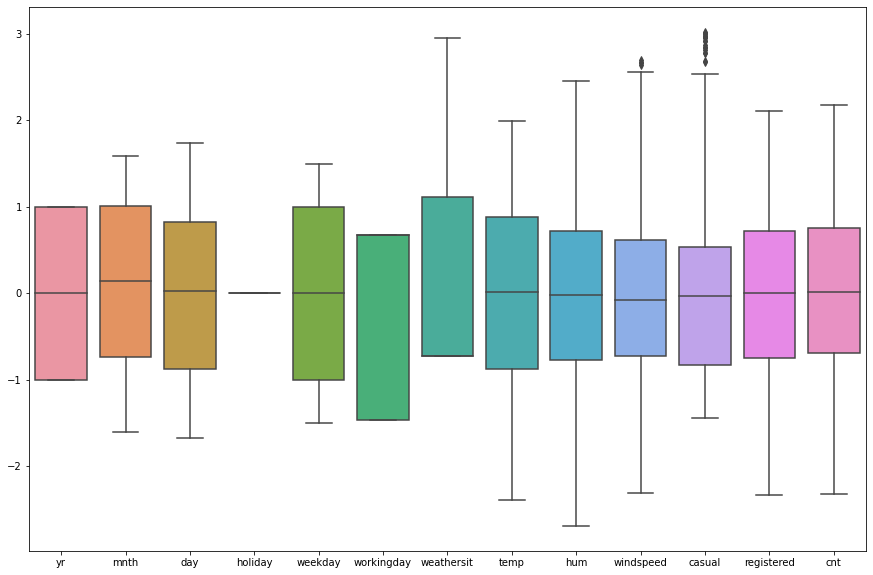

In [ ]:
scaler = StandardScaler()
col_escaladas = scaler.fit_transform(df_num_datos)

df_num_esc2 = pd.DataFrame(col_escaladas, columns = df_num_datos.columns)
df_num_esc2.head(2)
plt.figure(figsize= (15, 10))
sns.boxplot(data = df_num_esc2)



- <font color = orange> ¿Quizá no tiene sentido estandarizar aquí?
- ¿Qué pasa con la humedad?
- Holidays solo es 0 y 1, ¿la consideramos categórica codificada (sí/no)?

In [ ]:
df_num_esc2.corr()

,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
yr,1.000000e+00,-1.645563e-16,4.197556e-17,NaN,-0.005466,-0.002945,-0.050322,0.048666,-0.125276,-0.024802,0.166434,0.596911,0.569728
mnth,-1.645563e-16,1.000000e+00,1.189318e-02,NaN,0.009523,-0.004688,0.045613,0.219109,0.217538,-0.189453,0.161441,0.291952,0.278191
day,4.197556e-17,1.189318e-02,1.000000e+00,NaN,-0.000432,0.008521,-0.026178,0.026017,0.038732,0.020345,0.006157,-0.021729,-0.021419
holiday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday,-5.466369e-03,9.522969e-03,-4.318179e-04,NaN,1.000000,0.035800,0.031112,-0.000279,-0.043854,0.010554,0.010763,0.057427,0.067534
workingday,-2.945396e-03,-4.687953e-03,8.520708e-03,NaN,0.035800,1.000000,0.060236,0.053266,0.021589,-0.009178,-0.372252,0.305437,0.062542
weathersit,-5.032247e-02,4.561335e-02,-2.617822e-02,NaN,0.031112,0.060236,1.000000,-0.119328,0.617358,0.062787,-0.275783,-0.259025,-0.295929
temp,4.866569e-02,2.191093e-01,2.601732e-02,NaN,-0.000279,0.053266,-0.119328,1.000000,0.125564,-0.139567,0.582714,0.539345,0.627003
hum,-1.252759e-01,2.175383e-01,3.873165e-02,NaN,-0.043854,0.021589,0.617358,0.125564,1.000000,-0.200888,-0.077426,-0.110206,-0.119284
windspeed,-2.480179e-02,-1.894527e-01,2.034504e-02,NaN,0.010554,-0.009178,0.062787,-0.139567,-0.200888,1.000000,-0.179798,-0.203735,-0.216045


### ¿QUÉ PASA CON HOLIDAY?

<AxesSubplot:>

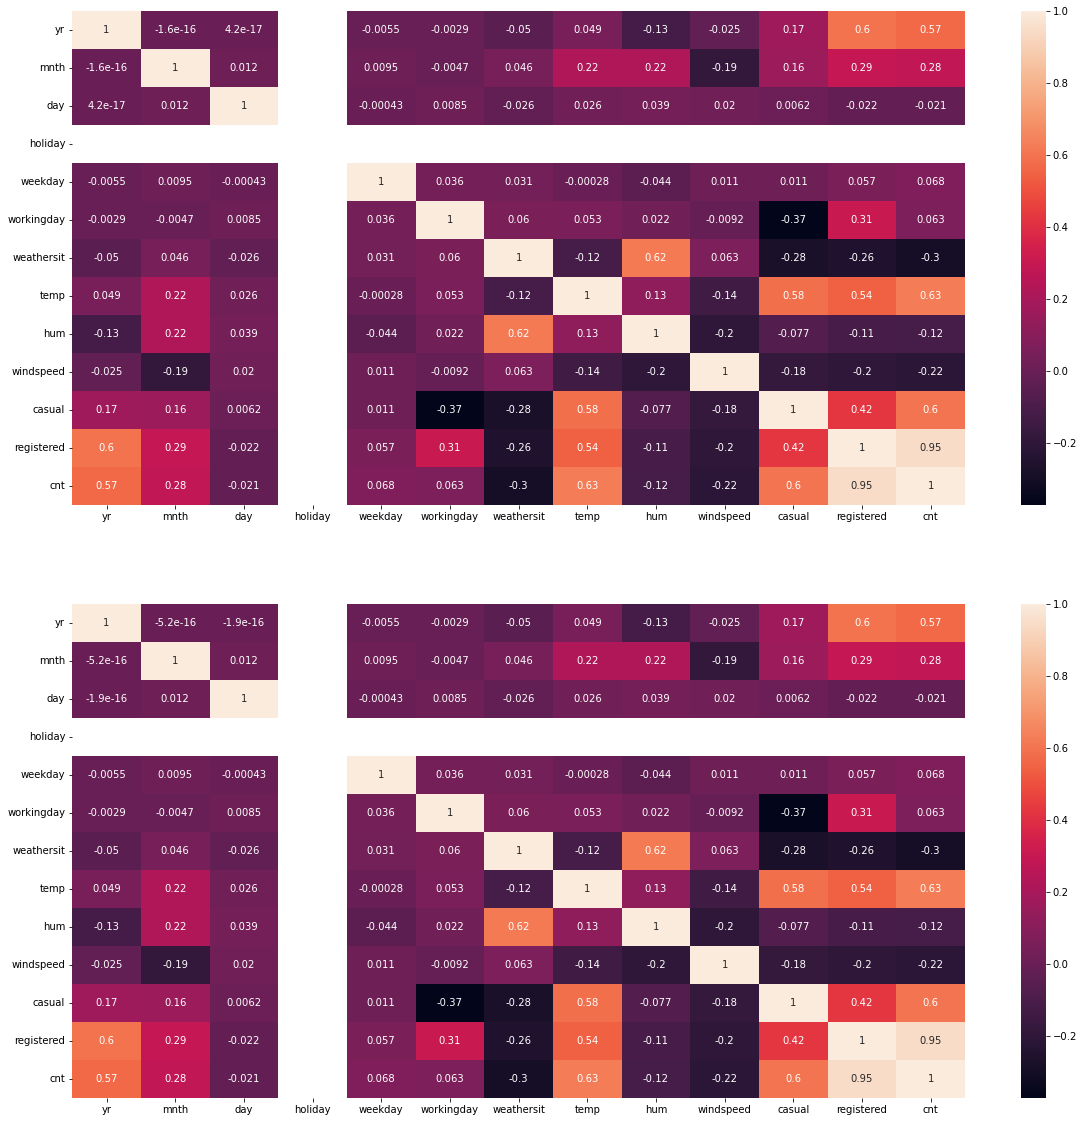

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (20, 20))
sns.heatmap(df_num_esc2.corr(), annot= True, ax = ax[0])
sns.heatmap(df_num_datos.corr(), annot = True, ax = ax[1])

De un primer vistazo podemos ver que lo que más afecta a los registros es la temperatura. 

### <font color=orange> ASUNCIONES:
- Normalidad --> miramos la normalidad de la variable respuesta (lo ha hecho Laura abajo)
- Independencia --> 
- Homocedasticidad 

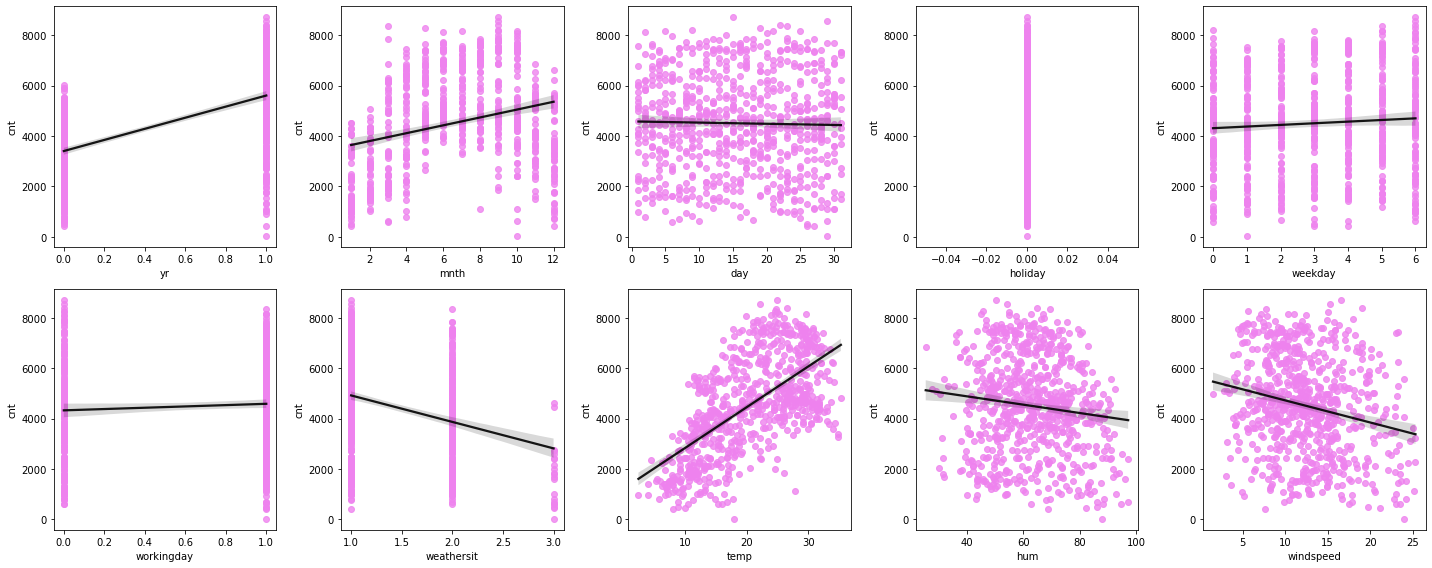

In [ ]:
# HOMOCEDASTICIDAD

fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 8)) 

axes = axes.flat 
predictoras = df_num_datos.drop(columns = ["cnt", "registered", "casual"], axis = 1)
col_pred = predictoras.columns


for i, column in enumerate(col_pred):
    sns.regplot( data = df_num_datos, x = column, y = 'cnt', color = "violet", line_kws = {"color": "black", "alpha": 0.9 }, ax = axes[i]) 
    fig.tight_layout();

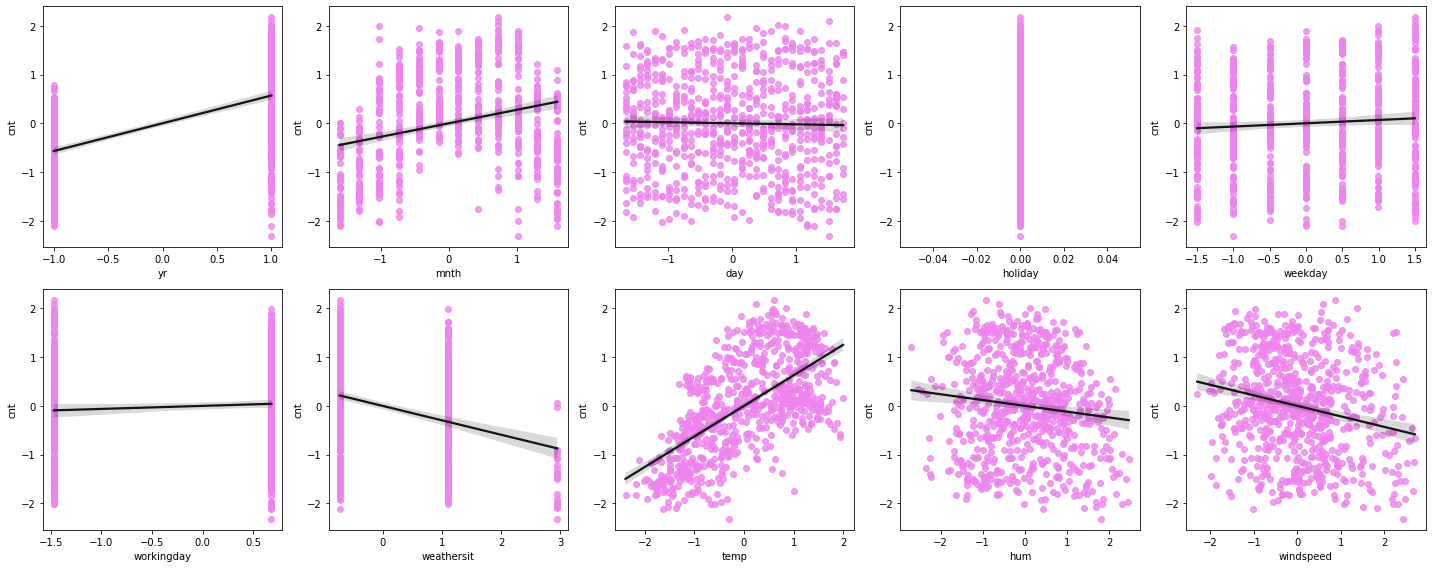

In [ ]:
# HOMOCEDASTICIDAD

fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 8)) 

axes = axes.flat 
predictoras = df_num_esc2.drop(columns = [["cnt", "registered", "casual"]])
col_pred = predictoras.columns


for i, column in enumerate(col_pred):
    sns.regplot( data = df_num_esc2, x = column, y = 'cnt', color = "violet", line_kws = {"color": "black", "alpha": 0.9 }, ax = axes[i]) 
    fig.tight_layout();

TEST HOMOCEDASTICIDAD

In [ ]:

resultados = {}

#iteremos por la lista de las columnas numéricas
for col in col_pred:
    # calculamos el p-valor de test
    statistic, p_val = levene(df[col], df_num_datos["cnt"], center='median')
    # lo almacenamos en el charges
    resultados[col] = p_val

In [ ]:
resultados

{'yr': 1.5274213964794415e-221,
 'mnth': 4.823769876689766e-221,
 'day': 4.093456833278303e-220,
 'holiday': 1.228812000205092e-221,
 'weekday': 2.6841048126566987e-221,
 'workingday': 1.4034088907459814e-221,
 'weathersit': 1.4549531050765028e-221,
 'temp': 2.483823693494982e-220,
 'hum': 2.661966368264321e-219,
 'windspeed': 7.971838325935599e-221}

<font color = orange> **CONCLUSIÓN**
SON HOMOCEDÁSTICAS (p valor > 0'05):
- ¿Ninguna?

### COMPROBACIÓN DE INDEPENDENCIA

In [ ]:
cols = df_num_datos.columns
comb = list(itertools.combinations(cols, 2))

In [ ]:
for par in comb:
    crosstab, results, expected = rp.crosstab(df_num_datos[par[0]], df_num_datos[par[1]],
                                                test = "chi-square",
                                                expected_freqs = True,
                                                 prop = "cell")
    print(par[0],"______________",par[1])
    print(results)

yr ______________ mnth
                 Chi-square test  results
0  Pearson Chi-square ( 11.0) =       0.0
1                     p-value =       1.0
2                  Cramer's V =       0.0
yr ______________ day
                 Chi-square test  results
0  Pearson Chi-square ( 30.0) =       0.0
1                     p-value =       1.0
2                  Cramer's V =       0.0
yr ______________ holiday
                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    0.0490
1                    p-value =    0.8248
2               Cramer's phi =    0.0082
yr ______________ weekday
                Chi-square test  results
0  Pearson Chi-square ( 6.0) =    0.0383
1                    p-value =    1.0000
2                 Cramer's V =    0.0072
yr ______________ workingday
                Chi-square test  results
0  Pearson Chi-square ( 1.0) =    0.0063
1                    p-value =    0.9366
2               Cramer's phi =    0.0029
yr ______________ weathersit
                C

SON dependientes:
- Humedad / viento
- Temperatura / viento 
- Weathersit / Hum
- weekday ______________ workingday
- holiday ______________ workingday
- holiday ______________ weekday
- mnth ______________ temp
- mnth ______________ weathersit

### <font color=orange> ANOVA

- <font color = "orange"> Ya hemos visto que algunas variables no cumplen las asunciones de la regresión lineal.
- Con ANOVA vamos a ver si las variables son importantes ("significativas a la hora de predecir") para la respuesta, por eso vamos a poner todas, y vamos viendo.

In [ ]:
cols

Index(['yr', 'mnth', 'day', 'holiday', 'weekday', 'workingday', 'weathersit',
       'temp', 'hum', 'windspeed', 'casual', 'registered', 'cnt'],
      dtype='object')

In [ ]:
ls = ols("cnt ~ yr + mnth + day + holiday + weekday+ workingday + weathersit + temp + hum + windspeed", data=df_num_datos).fit()
sm.stats.anova_lm(ls)

,df,sum_sq,mean_sq,F,PR(>F)
yr,1.0,8.869095e+08,8.869095e+08,1018.108839,6.321647e-140
mnth,1.0,2.114606e+08,2.114606e+08,242.741651,2.221899e-47
day,1.0,1.671009e+06,1.671009e+06,1.918199,1.664843e-01
holiday,1.0,6.246272e+05,6.246272e+05,0.717027,3.974020e-01
weekday,1.0,1.264701e+07,1.264701e+07,14.517868,1.506971e-04
workingday,1.0,1.111118e+07,1.111118e+07,12.754843,3.787089e-04
weathersit,1.0,2.273801e+08,2.273801e+08,261.016185,2.484621e-50
temp,1.0,7.280481e+08,7.280481e+08,835.747329,1.409854e-122
hum,1.0,1.605518e+06,1.605518e+06,1.843020,1.750227e-01
windspeed,1.0,2.384833e+07,2.384833e+07,27.376185,2.198785e-07


In [ ]:
ls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     268.5
Date:                Wed, 08 Jun 2022   Prob (F-statistic):          2.57e-223
Time:                        23:22:22   Log-Likelihood:                -6023.1
No. Observations:                 730   AIC:                         1.207e+04
Df Residuals:                     720   BIC:                         1.211e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1810.5005    248.369      7.290      0.000    1322.886    2298.115
yr          2029.3978     70.021     28.983      0.000    1891.927    2166.868
mnth          91.9847     10.580      8.694      0.000      71.213     112.756
day           -8.2555      3.943     -2.094      0.037     -15.997      -0.514
holiday     -1.65e-12   2.95e-13     -5.596      0.000   -2.23e-12   -1.07e-12
weekday       68.2636     17.318      3.942      0.000      34.264     102.264
workingday   186.2724     74.664      2.495      0.013      39.687     332.858
weathersit  -605.5005     86.456     -7.004      0.000    -775.236    -435.765
temp         138.8853      4.901     28.337      0.000     129.263     148.508
hum           -9.4414      3.501     -2.696      0.007     -16.316      -2.567
windspeed    -40.3248      7.717     -5.226      0.000     -55.475     -25.175
==============================================================================
Omnibus:                       69.765   Durbin-Watson:                   0.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.491
Skew:                          -0.655   Prob(JB):                     2.27e-25
Kurtosis:                       4.419   Cond. No.                     1.83e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.09e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
def get_VIF(dataframe, target):
        X = add_constant(dataframe.loc[:, dataframe.columns != target])
        seriesObject = pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])] , index=X.columns,).sort_values(ascending= False)
        return seriesObject

In [ ]:
get_VIF(df_num_esc2, "cnt")

registered    5.108004
yr            2.522762
casual        2.515015
temp          2.363625
workingday    2.090887
hum           2.015943
weathersit    2.002641
mnth          1.311299
windspeed     1.180728
weekday       1.022859
day           1.015260
const         1.000000
holiday            NaN
dtype: float64

### <font color=orange> ASUNCIONES PARA UN MODELO DE REGRESIÓN LINEAL:
- Independencia
- Linealidad
- Homocedasticidad
- Normalidad

# OUTLIERS

Hacer un describe

In [ ]:
pd.set_option("display.float_format",lambda x: "%3.f" %x) #Usamos esta linea de código para que no aparezca los exponenciales
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season_encoding,730,2,1,1,1,2,3,3
yr,730,0,1,0,0,0,1,1
mnth,730,7,3,1,4,7,10,12
day,730,16,9,1,8,16,23,31
holiday,730,0,0,0,0,0,0,1
weekday,730,3,2,0,1,3,5,6
workingday,730,1,0,0,0,1,1,1
weathersit,730,1,1,1,1,1,2,3
temp,730,20,8,2,14,20,27,35
temp_interval_ord,730,3,1,1,2,3,4,5


In [ ]:
pd.set_option("display.float_format",lambda x: "%3.f" %x) #Usamos esta linea de código para que no aparezca los exponenciales
df_num_datos.describe().T

,count,mean,std,min,25%,50%,75%,max
yr,730,0,1,0,0,0,1,1
mnth,730,7,3,1,4,7,10,12
day,730,16,9,1,8,16,23,31
holiday,730,0,0,0,0,0,0,1
weekday,730,3,2,0,1,3,5,6
workingday,730,1,0,0,0,1,1,1
weathersit,730,1,1,1,1,1,2,3
temp,730,20,8,2,14,20,27,35
hum,730,63,14,0,52,63,73,97
windspeed,730,13,5,2,9,12,16,34


In [ ]:
df_num_datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          730 non-null    int64  
 1   mnth        730 non-null    int64  
 2   day         730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  casual      730 non-null    int64  
 11  registered  730 non-null    int64  
 12  cnt         730 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 79.8 KB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_encoding    730 non-null    int64  
 1   season             730 non-null    object 
 2   yr                 730 non-null    int64  
 3   mnth               730 non-null    int64  
 4   day                730 non-null    int64  
 5   holiday            730 non-null    int64  
 6   weekday            730 non-null    int64  
 7   workingday         730 non-null    int64  
 8   weathersit         730 non-null    int64  
 9   temp               730 non-null    float64
 10  temp_interval      730 non-null    object 
 11  temp_interval_ord  730 non-null    int64  
 12  temp_interval_num  730 non-null    object 
 13  hum                730 non-null    float64
 14  hum_interval       730 non-null    object 
 15  hum_interval_num   730 non-null    object 
 16  hum_interval_ord   730 non

Tenemos outliers? ¿Que hacemos con ellos?

PRIMERO SELECCIONA LAS VARIABLES NUMÉRCIAS

In [ ]:
df_numericas= df.select_dtypes(include="int64")

In [ ]:
len(df_numericas.columns)

13

In [ ]:
len(df_num_datos.columns)

13

BOXPLOT PARA VER 

<AxesSubplot:>

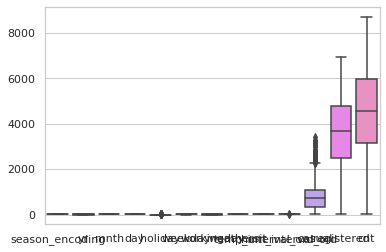

In [ ]:
sns.boxplot(data = df_numericas)

<AxesSubplot:>

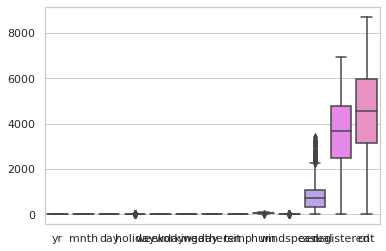

In [ ]:
sns.boxplot(data=df_num_datos)

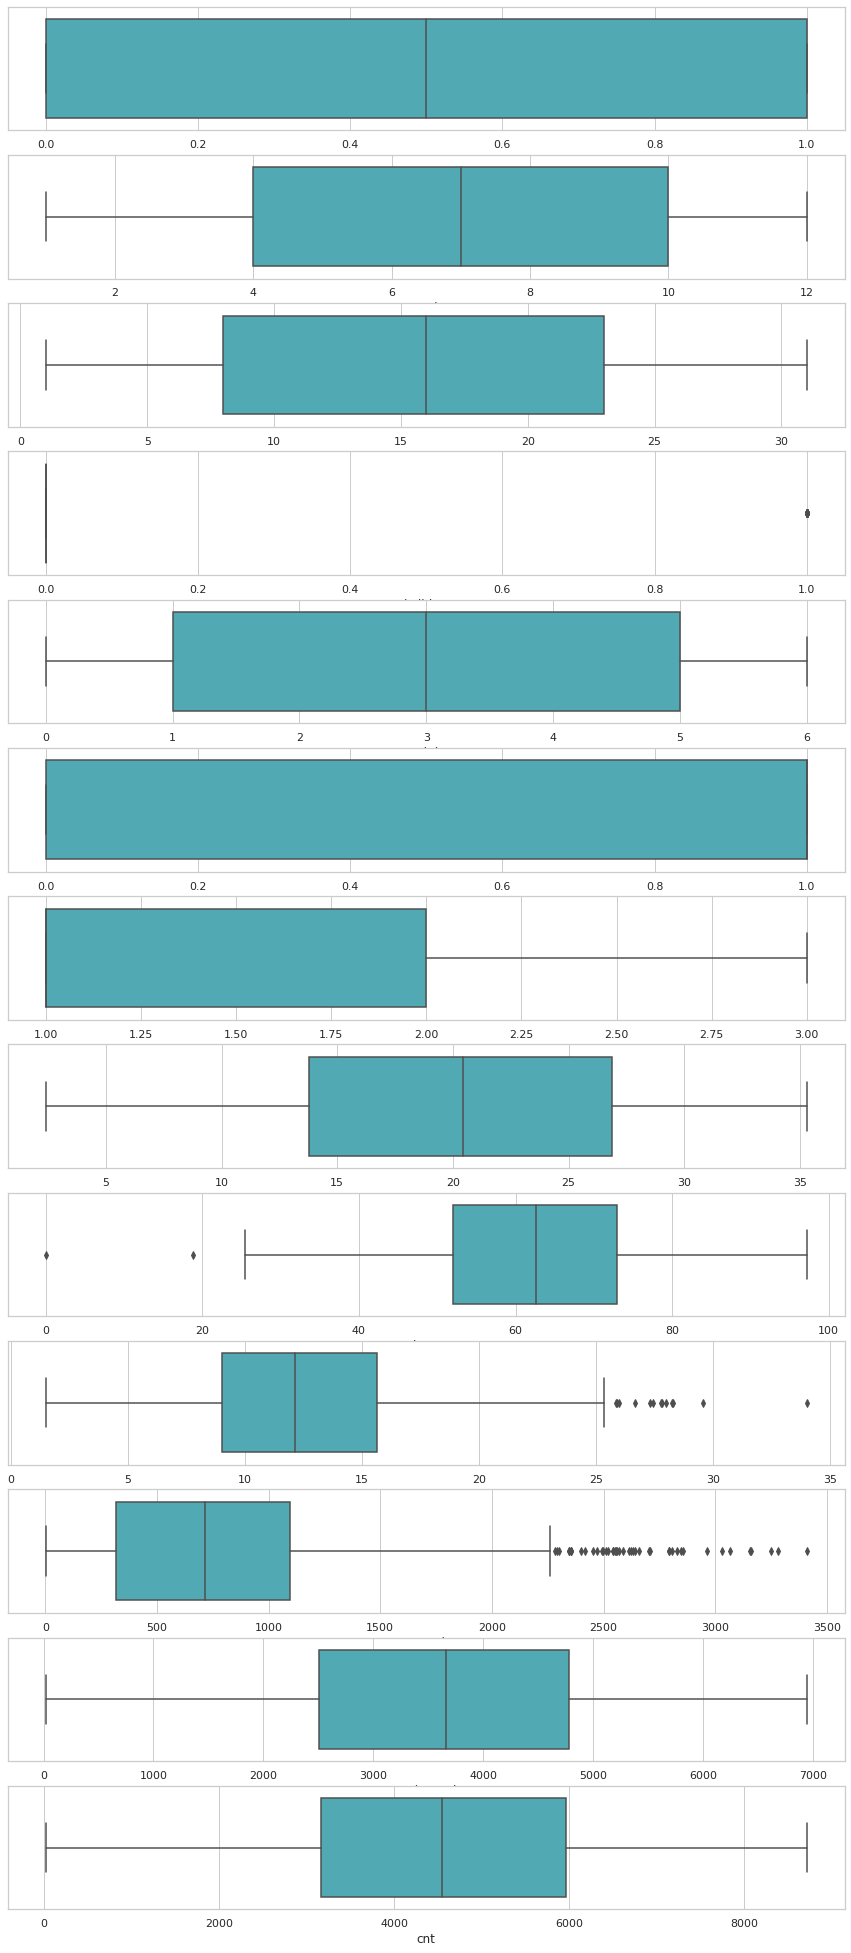

In [ ]:
fig, axes = plt.subplots(13, 1, figsize=(15,35))
for i in range(len(df_num_datos.columns)):
    sns.boxplot(x = df_num_datos.columns[i], data = df,palette= "YlGnBu", ax=axes[i]); # para trazar una línea de densidad

plt.show()

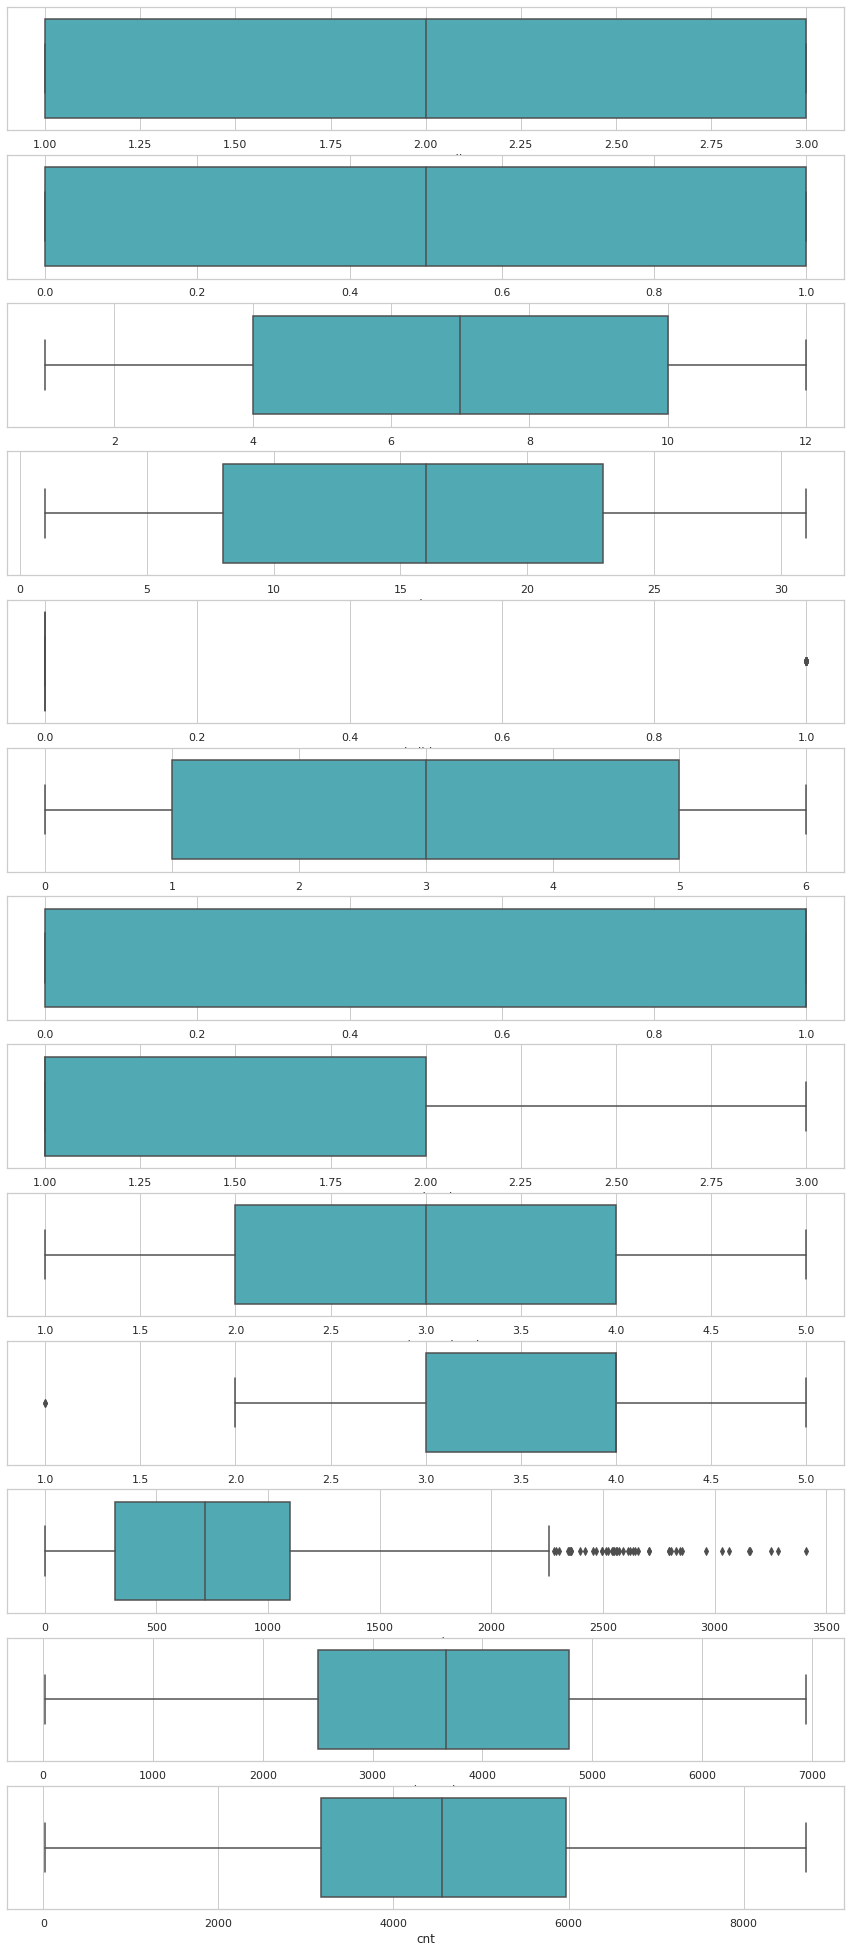

In [ ]:
fig, axes = plt.subplots(13, 1, figsize=(15,35))
for i in range(len(df_numericas.columns)):
    sns.boxplot(x = df_numericas.columns[i], data = df,palette= "YlGnBu", ax=axes[i]); # para trazar una línea de densidad

plt.show()

VOY A DETECTAR LOS OUTLIERS

In [ ]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} 
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
    
    return dicc_indices 

In [ ]:
lista_columnas = list(df_num_datos.columns)
ind = detectar_outliers(lista_columnas, df_num_datos)
print(ind)
for k, v in ind.items():
    mediana = df[k].median() 
    for i in v: 
        df.loc[i,k] = mediana

{'holiday': [16, 51, 104, 149, 184, 247, 282, 314, 327, 359, 366, 380, 415, 470, 512, 549, 610, 645, 680, 690, 723], 'hum': [49, 68], 'windspeed': [44, 49, 93, 94, 292, 382, 407, 420, 431, 432, 449, 665, 720], 'casual': [148, 183, 184, 196, 246, 281, 440, 446, 454, 455, 461, 468, 469, 475, 489, 496, 503, 504, 510, 511, 512, 517, 518, 524, 531, 532, 538, 539, 549, 559, 567, 580, 594, 608, 609, 616, 622, 629, 630, 636, 643, 657, 664, 679]}


VUELVE A REVISAR EL DESCRIBE PARA VER SI QUIERES SUSTITUIR UN VALOR

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season_encoding,730,2,1,1,1,2,3,3
yr,730,0,1,0,0,0,1,1
mnth,730,7,3,1,4,7,10,12
day,730,16,9,1,8,16,23,31
holiday,730,0,0,0,0,0,0,0
weekday,730,3,2,0,1,3,5,6
workingday,730,1,0,0,0,1,1,1
weathersit,730,1,1,1,1,1,2,3
temp,730,20,8,2,14,20,27,35
temp_interval_ord,730,3,1,1,2,3,4,5


In [ ]:
# POR SI QUIERO CAMBIAR ALGUNA COLUMNA POR ALGUNA VALOR: DE MEDIANA , MEDIA, MODA
[df["price"].replace({x:71},inplace=True) for x in df["price"]]

#OTRAS OPCIONES
for k,v in ind.items():
    mediana= df[k].median()
    for i in v:
       df.loc[i,k] = mediana 

#OTRAS KNN METODO(VECINOS)


VUELVES A REVISAR BOXPLOT PARA VER SI YA NO TIENES OUTLIERS

IndexError: index 3 is out of bounds for axis 0 with size 3

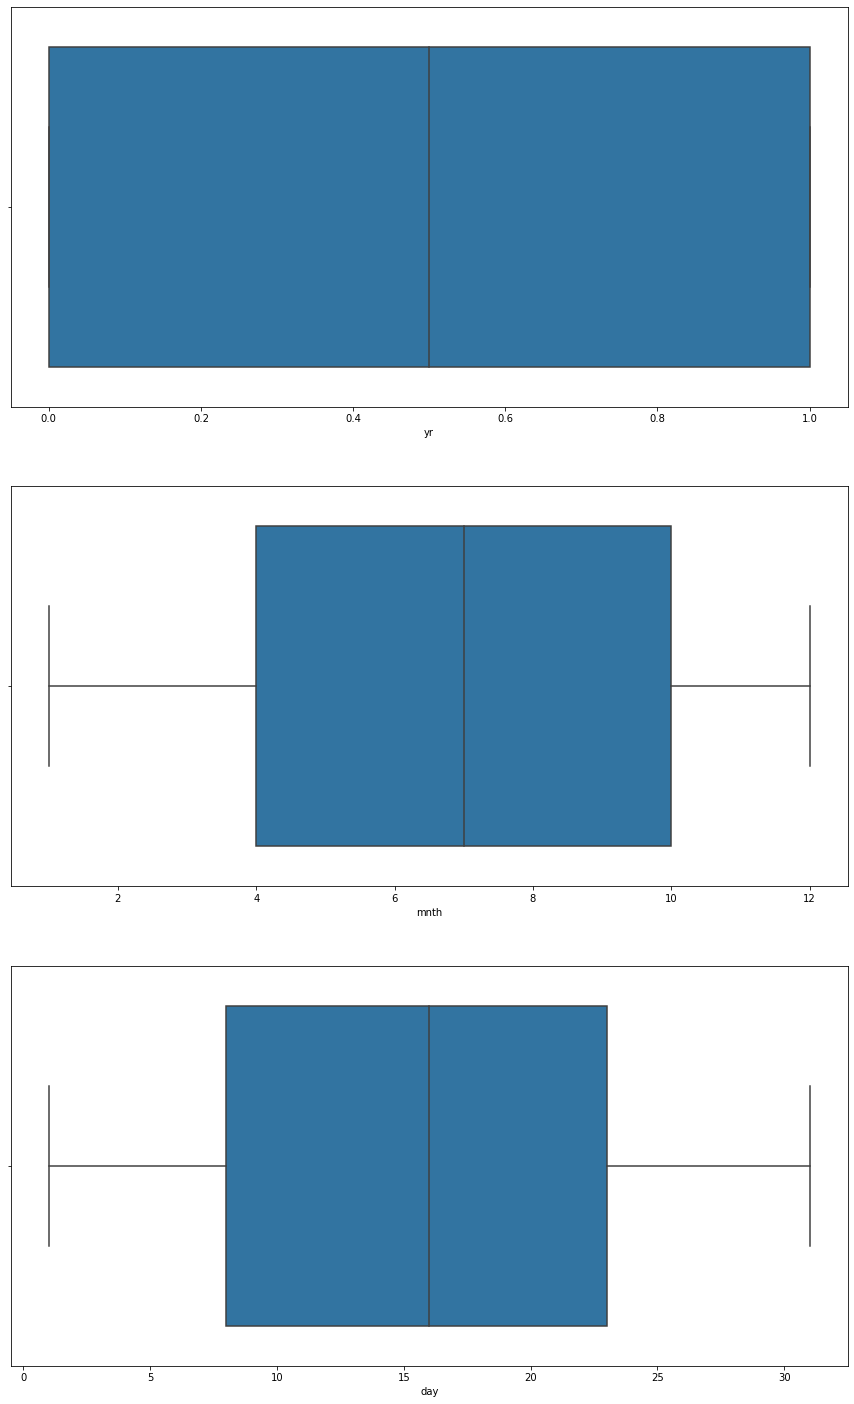

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(15,25))

for i in range(len(df_num_datos.columns)):
    sns.boxplot(x = df_num_datos.columns[i], data = df, ax=axes[i]); # para trazar una línea de densidad

plt.show()

 - No quedan outliers en df_num_datos

In [ ]:
df_encoded.head(2)

,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp_interval_ord,hum_interval_ord,wind_num_encoding,casual,registered,cnt
0,1,0,1,1,0,6,0,2,2,5,1,331,654,985
1,1,0,1,2,0,0,0,2,2,4,2,131,670,801


# <font color="purple"> PREPARACIÓN REGRESIÓN

# YA DEBE ESTAR TODO LIMPIO , CON ENCOGING, COLUMNAS NUMERICAS Y CATEGORICAS, TODO COMPLETITO PARA SIGUIENTE PASO

REGRESIÓN SIMPLE DE LAS 3 VARIABLES DEPENDIENTE :

Y = ¿CUANTAS BICIS SE RESERVAN EN 2018 Y 2019 EN GENERAL "CNT"?

Y1 = ¿CUANTAS BICIS SE RESERVAN EN 2018 Y 2019 CLIENTES registered ? 

Y2= ¿CUANTAS BICIS SE RESERVAN EN 2018 Y 2019 CLIENTES CASUAL?

### REGRESION LINEAL MULTIPLE CON VARIABLES NUMÉRICAS Y CATEGORIAS

🚨🚨 PRIMERO HAGO UN GROUPBY DE COMO VA A SER MI DF, POR QUE HEMOS INCLUIDO COLUMNAS EXTRAS , REDUNDANTES Y CATEGORICAS, QUE SOLO NOS HAN SERVIDO AL PRINCIPIO PARA LAS GRAFICAS.

HACEMOS LA CORRELACION DE LAS VARIABLES INDEPENDIENTES( AQUELLAS A QUIENES PREGUNTAMOS ESPERANDO LA RESPUESTA (Y))

In [ ]:
df_encoded.columns

Index(['season_encoding', 'yr', 'mnth', 'day', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp_interval_ord', 'hum_interval_ord',
       'wind_num_encoding', 'casual', 'registered', 'cnt'],
      dtype='object')

- Correlación para las variables independientes

In [ ]:
df_encoded.drop(columns = ['casual','registered','cnt']).corr() 


,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp_interval_ord,hum_interval_ord
season_encoding,1,0,1,0,-0,0,0,0,-0,0
yr,0,1,-0,-0,0,-0,-0,-0,0,-0
mnth,1,-0,1,0,0,0,-0,0,0,0
day,0,-0,0,1,-0,-0,0,-0,0,0
holiday,-0,0,0,-0,1,-0,-0,-0,-0,-0
weekday,0,-0,0,-0,-0,1,0,0,-0,-0
workingday,0,-0,-0,0,-0,0,1,0,0,0
weathersit,0,-0,0,-0,-0,0,0,1,-0,1
temp_interval_ord,-0,0,0,0,-0,-0,0,-0,1,0
hum_interval_ord,0,-0,0,0,-0,-0,0,1,0,1


<AxesSubplot:>

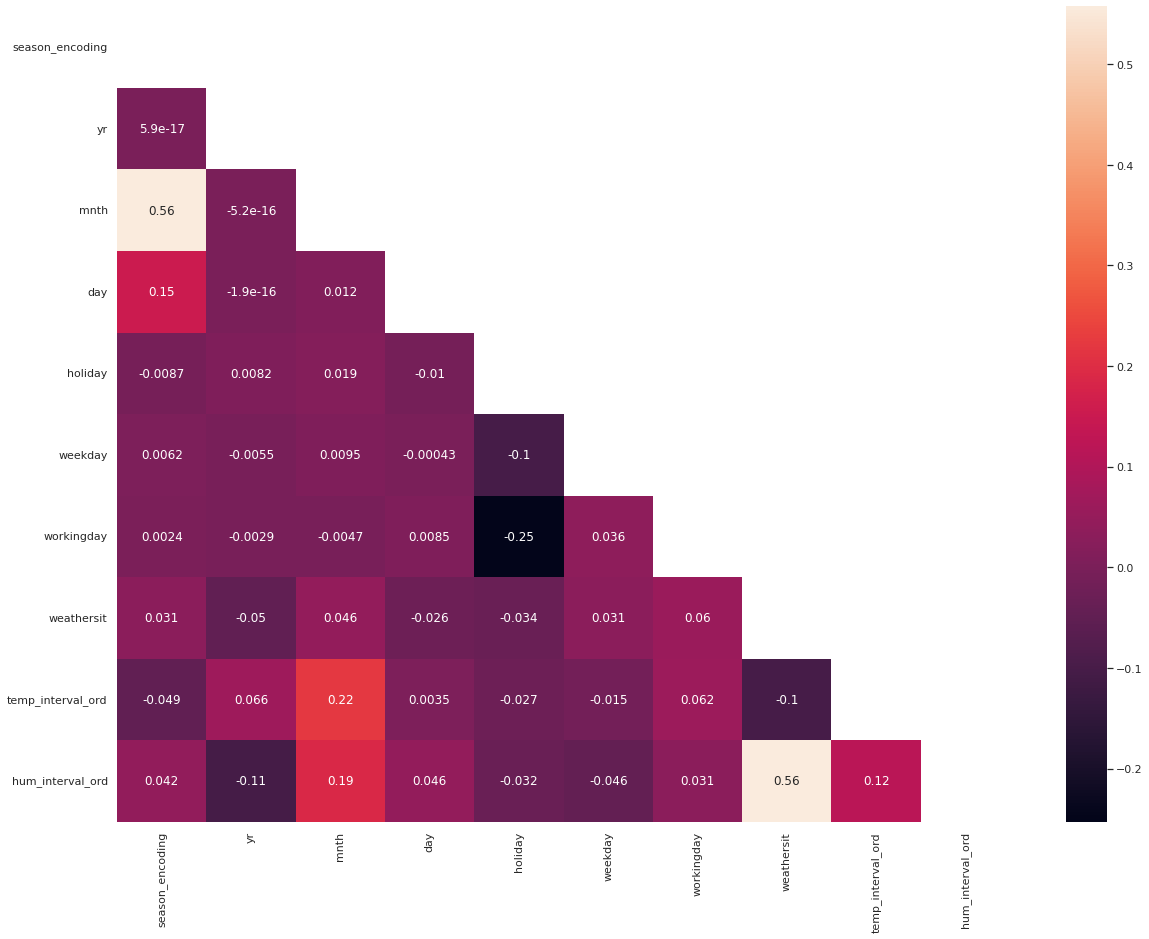

In [ ]:
fig, ax = plt.subplots(figsize = (20,15))
corr = df_encoded.drop(columns = ['casual','registered','cnt']).corr() 
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,mask = mask,xticklabels=corr.columns.values,yticklabels=corr.columns.values, annot= True )

<font color="purple"> Deducimos que las variables están poco correlacionadas entre sí, por lo que de mometo las dejamos todas. Ojo! ¿Será que hay algo mal? porque season encoding tal vez debería relacionarse más con month

- Covarianza variables independientes (nos sirve solo para saber el sentido relación)

In [ ]:
df_encoded.drop(columns = ['casual','registered','cnt']).cov() 

,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp_interval_ord,hum_interval_ord
season_encoding,1,0,2,1,-0,0,0,0,-0,0
yr,0,0,-0,0,0,-0,-0,-0,0,-0
mnth,2,-0,12,0,0,0,-0,0,1,0
day,1,0,0,77,-0,-0,0,-0,0,0
holiday,-0,0,0,-0,0,-0,-0,-0,-0,-0
weekday,0,-0,0,-0,-0,4,0,0,-0,-0
workingday,0,-0,-0,0,-0,0,0,0,0,0
weathersit,0,-0,0,-0,-0,0,0,0,-0,0
temp_interval_ord,-0,0,1,0,-0,-0,0,-0,1,0
hum_interval_ord,0,-0,0,0,-0,-0,0,0,0,1


- Correlación variables Dependientes o Predictoras

In [ ]:
df_encoded.head()

,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp_interval_ord,hum_interval_ord,wind_num_encoding,casual,registered,cnt
0,1,0,1,1,0,6,0,2,2,5,1,331,654,985
1,1,0,1,2,0,0,0,2,2,4,2,131,670,801
2,1,0,1,3,0,1,1,1,1,3,2,120,1229,1349
3,1,0,1,4,0,2,1,1,1,4,1,108,1454,1562
4,1,0,1,5,0,3,1,1,2,3,1,82,1518,1600


<AxesSubplot:>

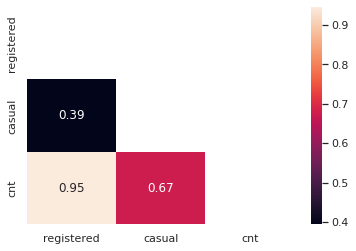

In [ ]:
fig, ax = plt.subplots(figsize = (6,4))
corr = df_encoded[["registered", "casual", "cnt"]].corr() 
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,mask = mask,xticklabels=corr.columns.values,yticklabels=corr.columns.values, annot= True )

- Anova

In [ ]:
lm_cnt = ols('cnt ~ season_encoding + yr + mnth + day + holiday + weekday + workingday + weathersit + temp_interval_ord + hum_interval_ord + wind_num_encoding', data=df).fit()
sm.stats.anova_lm(lm_cnt)

,df,sum_sq,mean_sq,F,PR(>F)
wind_num_encoding,4,163392424,40848106,46,0
season_encoding,1,22673,22673,0,1
yr,1,887573213,887573213,1009,0
mnth,1,234008470,234008470,266,0
day,1,180395,180395,0,1
holiday,1,16648746,16648746,19,0
weekday,1,10251806,10251806,12,0
workingday,1,5988980,5988980,7,0
weathersit,1,203047978,203047978,231,0
temp_interval_ord,1,578636214,578636214,658,0


In [ ]:
lm_cnt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     170.9
Date:                Tue, 07 Jun 2022   Prob (F-statistic):          5.09e-217
Time:                        21:33:32   Log-Likelihood:                -6024.0
No. Observations:                 730   AIC:                         1.208e+04
Df Residuals:                     715   BIC:                         1.215e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       1575.1782    239.037      6.590      0.000    1105.879    2044.477
wind_num_encoding[T.2]            76.7575     86.549      0.887      0.375     -93.164     246.679
wind_num_encoding[T.3]          -761.0958    146.421     -5.198      0.000   -1048.562    -473.630
wind_num_encoding[T.very_high]  -864.2909    363.097     -2.380      0.018   -1577.154    -151.428
wind_num_encoding[T.very_low]    441.8796     99.577      4.438      0.000     246.381     637.378
season_encoding                 -167.8001     52.585     -3.191      0.001    -271.040     -64.560
yr                              2040.1786     70.448     28.960      0.000    1901.869    2178.488
mnth                             113.4838     13.176      8.613      0.000      87.615     139.352
day                               -3.6350      4.032     -0.901      0.368     -11.552       4.282
holiday                         -637.2645    215.973     -2.951      0.003   -1061.281    -213.248
weekday                           74.4881     17.509      4.254      0.000      40.113     108.863
workingday                       123.8189     77.499      1.598      0.111     -28.333     275.971
weathersit                      -707.3303     80.469     -8.790      0.000    -865.314    -549.346
temp_interval_ord                820.3530     31.938     25.686      0.000     757.649     883.057
hum_interval_ord                -126.0953     60.127     -2.097      0.036    -244.141      -8.049
==============================================================================
Omnibus:                       30.723   Durbin-Watson:                   1.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.387
Skew:                          -0.420   Prob(JB):                     4.62e-09
Kurtosis:                       3.746   Cond. No.                         209.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
lm_reg = ols('registered ~ season_encoding + yr + mnth + day + holiday + weekday + workingday + weathersit + temp_interval_ord + hum_interval_ord + wind_num_encoding', data=df).fit()
sm.stats.anova_lm(lm_reg) # vamos a obviar esta variable dependiente porque está muy correlacionada con 'cnt' y 

,df,sum_sq,mean_sq,F,PR(>F)
wind_num_encoding,4.0,8.939514e+07,2.234878e+07,42.019649,1.144892e-31
season_encoding,1.0,1.850188e+06,1.850188e+06,3.478679,6.257376e-02
yr,1.0,6.286011e+08,6.286011e+08,1181.880756,1.236237e-153
mnth,1.0,1.522606e+08,1.522606e+08,286.276705,2.892905e-54
day,1.0,1.124122e+04,1.124122e+04,0.021135,8.844515e-01
holiday,1.0,2.496966e+07,2.496966e+07,46.947349,1.574878e-11
weekday,1.0,3.816088e+06,3.816088e+06,7.174918,7.562859e-03
workingday,1.0,1.463867e+08,1.463867e+08,275.232849,1.546710e-52
weathersit,1.0,1.111164e+08,1.111164e+08,208.918378,9.904001e-42
temp_interval_ord,1.0,2.335199e+08,2.335199e+08,439.058547,2.246278e-76


In [ ]:
lm_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             registered   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     187.1
Date:                Tue, 07 Jun 2022   Prob (F-statistic):          6.14e-228
Time:                        21:33:19   Log-Likelihood:                -5840.5
No. Observations:                 730   AIC:                         1.171e+04
Df Residuals:                     715   BIC:                         1.178e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        933.5529    185.897      5.022      0.000     568.584    1298.521
wind_num_encoding[T.2]            23.9055     67.308      0.355      0.723    -108.240     156.051
wind_num_encoding[T.3]          -552.8007    113.870     -4.855      0.000    -776.360    -329.242
wind_num_encoding[T.very_high]  -441.9956    282.376     -1.565      0.118    -996.381     112.390
wind_num_encoding[T.very_low]    277.7467     77.440      3.587      0.000     125.710     429.784
season_encoding                 -127.9523     40.895     -3.129      0.002    -208.241     -47.664
yr                              1752.8973     54.786     31.995      0.000    1645.336    1860.459
mnth                             108.6531     10.247     10.603      0.000      88.535     128.771
day                               -3.5671      3.136     -1.138      0.256      -9.724       2.590
holiday                         -339.3497    167.960     -2.020      0.044    -669.103      -9.597
weekday                           44.5311     13.616      3.270      0.001      17.798      71.264
workingday                       953.2410     60.270     15.816      0.000     834.914    1071.568
weathersit                      -556.4960     62.580     -8.893      0.000    -679.358    -433.634
temp_interval_ord                520.6860     24.838     20.963      0.000     471.922     569.450
hum_interval_ord                 -74.0853     46.760     -1.584      0.114    -165.888      17.718
==============================================================================
Omnibus:                       96.243   Durbin-Watson:                   0.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.123
Skew:                          -0.783   Prob(JB):                     1.41e-41
Kurtosis:                       4.932   Cond. No.                         209.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
lm_casu = ols('casual ~ season_encoding + yr + mnth + day + holiday + weekday + workingday + weathersit + temp_interval_ord + hum_interval_ord + wind_num_encoding', data=df).fit()
sm.stats.anova_lm(lm_casu)

,df,sum_sq,mean_sq,F,PR(>F)
wind_num_encoding,4.0,1.274284e+07,3.185711e+06,20.471339,5.522624e-16
season_encoding,1.0,1.463232e+06,1.463232e+06,9.402714,2.248302e-03
yr,1.0,2.228075e+07,2.228075e+07,143.175794,3.322089e-30
mnth,1.0,8.749432e+06,8.749432e+06,56.223744,1.919979e-13
day,1.0,1.015725e+05,1.015725e+05,0.652704,4.194164e-01
holiday,1.0,8.402969e+05,8.402969e+05,5.399737,2.041924e-02
weekday,1.0,1.558410e+06,1.558410e+06,10.014326,1.619102e-03
workingday,1.0,9.315723e+07,9.315723e+07,598.627244,1.603947e-96
weathersit,1.0,1.375160e+07,1.375160e+07,88.367592,7.189860e-20
temp_interval_ord,1.0,7.697431e+07,7.697431e+07,494.635944,1.079715e-83


In [ ]:
lm_casu.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 casual   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     106.6
Date:                Tue, 07 Jun 2022   Prob (F-statistic):          2.71e-164
Time:                        21:35:20   Log-Likelihood:                -5391.9
No. Observations:                 730   AIC:                         1.081e+04
Df Residuals:                     715   BIC:                         1.088e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        641.6254    100.554      6.381      0.000     444.208     839.042
wind_num_encoding[T.2]            52.8519     36.408      1.452      0.147     -18.628     124.332
wind_num_encoding[T.3]          -208.2951     61.594     -3.382      0.001    -329.222     -87.369
wind_num_encoding[T.very_high]  -422.2953    152.742     -2.765      0.006    -722.171    -122.420
wind_num_encoding[T.very_low]    164.1329     41.888      3.918      0.000      81.894     246.372
season_encoding                  -39.8478     22.121     -1.801      0.072     -83.277       3.582
yr                               287.2813     29.635      9.694      0.000     229.100     345.463
mnth                               4.8307      5.543      0.872      0.384      -6.051      15.713
day                               -0.0678      1.696     -0.040      0.968      -3.398       3.262
holiday                         -297.9148     90.852     -3.279      0.001    -476.283    -119.546
weekday                           29.9569      7.365      4.067      0.000      15.497      44.417
workingday                      -829.4221     32.601    -25.442      0.000    -893.427    -765.417
weathersit                      -150.8343     33.850     -4.456      0.000    -217.292     -84.376
temp_interval_ord                299.6670     13.435     22.305      0.000     273.290     326.044
hum_interval_ord                 -52.0100     25.293     -2.056      0.040    -101.668      -2.352
==============================================================================
Omnibus:                       61.303   Durbin-Watson:                   1.171
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.303
Skew:                           0.584   Prob(JB):                     1.01e-22
Kurtosis:                       4.402   Cond. No.                         209.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<font color = "purple" > Deducimos que cnt y registered están muy correlacionadas, por lo que habrá que tenerlo en cuenta cuando hagamos los modelos.

<font color = "purple" > El mejor modelo predictivo para nosotras con todas las v. ind y la v. dep `registered` y `cnt` (recuerda que tiene sentido pq están correlacionadas)

<font color = 'purple'> Ahora tenemos que ver que se cumplen las asunciones de la ANOVA para ver si nuestra anova DICE LA VERDAD y NOS PODEMOS FIAR DE ELLA.

- Comprobación asunciones de ANOVA: normalidad, homocedasticidad, independencia

    normalidad: shapiro

- Comprabamos normalidad

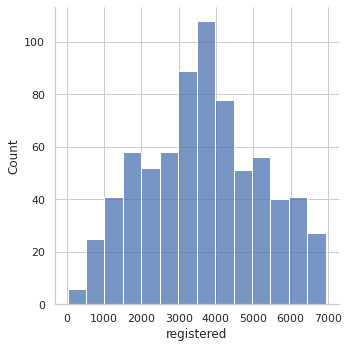

In [ ]:
sns.displot(df["registered"])

In [ ]:
#Hacemos de nuevo el shapiro a ver si lo hemos normalizado
stats.shapiro (df["registered"])

ShapiroResult(statistic=0.9802490472793579, pvalue=2.313480784721378e-08)

In [ ]:
df_encoded["registered"],lambda_ajustada= stats.boxcox(df["registered"])

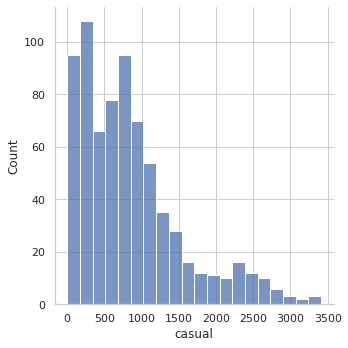

In [ ]:
sns.displot(df["casual"])

In [ ]:
stats.shapiro (df["casual"])

ShapiroResult(statistic=0.8850967288017273, pvalue=7.660028716313278e-23)

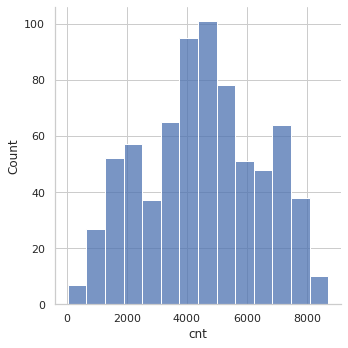

In [ ]:
sns.displot(df["cnt"])

In [ ]:
stats.shapiro (df["cnt"])

ShapiroResult(statistic=0.9802490472793579, pvalue=2.313480784721378e-08)

- Transformamos para que sean normales

In [ ]:
# Si no son normales podemos transformar por : LOG, RAIZ CUADRADA Y BOX COX(
df_encoded["cnt"],lambda_ajustada= stats.boxcox(df["cnt"])
df_encoded["registered"],lambda_ajustada= stats.boxcox(df["registered"])
df_encoded["casual"],lambda_ajustada= stats.boxcox(df["casual"])

<font color= purple> Me quedo, aquí! falta revisar homocedasticdad e indepencia. Atenta! hay que separar numéricas y categóricas?

- Otra asunción ANOVA: homocedasticidad

In [ ]:
# # Aquí comienza la resolucion del ejercicio 1
# residuals = (y_test - y_prediction)


# # 2. Independencia

# fig,ax = plt.subplots(figsize= (8,4))
# plt.scatter(x=y_test , y=residuals)
# plt.axline((float(min(y_prediction)),0),(float(max(y_prediction)),0),color="black",linestyle= '--') 
# plt.title('Gráfica de dispersion de dos conjuntos de datos')
# ax.set_xlabel('Longitud del sépalo conjunto test')
# ax.set_ylabel('Residuos')
# plt.show()


# # 3. Homocedasticidad

# fig,ax = plt.subplots(figsize= (8,4))
# plt.scatter(x=y_prediction , y=residuals)
# plt.axline((float(min(y_prediction)),0),(float(max(y_prediction)),0),color="black",linestyle= '--') 
# plt.title('Gráfica de dispersion de dos conjuntos de datos')
# ax.set_xlabel('Longitud del sépalo conjunto test predicho')
# ax.set_ylabel('Residuos')
# plt.show()

# # 4. Normalidad
# # preprocessing.normalize()
# fig = plt.figure()
# sns.distplot(residuals,bins = len(residuals))
# plt.show()
# sm.qqplot(residuals, line = '45', fit = True)
# py.show()

    homocedasticidad :  test levene

    pvalor < 0,05 NO SIGNIFICATIVO, CUMPLE ASUNCIÓN , TIENEN VARIANZAS SIMILARES
    P valor > 0,05 SIGNIFICATIVO , no cumple asunción, NO TIENEN VARIANZAS SIMILARES

    

In [ ]:
#se aplica a categoricas y numericas
#primera categoricas

fig,axes = plt.subplots(1,4,figsize =(30,10))

axes= axes.flat

colum_cat= df_encoded.select_dtypes(include=["object", "category"]).columns

for i,col in enumerate(colum_cat):
    sns,boxplot(
        x= col,
        y= "cnt",
        data= df_bike,
        palette= "tab10",
        ax= axes[i]
    )

In [ ]:
def datos_test_levene(columan,df):
    valoresr=df[columna].unique()
    d= {}

for x in valroes:
    d[x]= df[df(columna) == x]["cnt"]

Aqui nos saca los diferentes Dataframes

In [ ]:
sexo= detectar_test_levene("temperatura",df) #esta sobre la categorica creada low, high,...
smoker= detectar_test_levene("viento",df)
region= detectar_test_levene("humedad",df)
hijos= detectar_test_levene("season",df)

Ahora comprobamos levene para estos Df

In [ ]:
stats.levene(temperatura[0], temperatura[1], temperatura[2], temperatura[3], center = "median")
stats.levene(viento["low"], viento["high"], viento["2"], viento["3"], center = "median")
stats.levene(humedad["low"], humedad["high"], humedad["2"], humedad["3"], center = "median")
stats.levene(season["low"], season["high"], season["2"], season["3"], center = "median")

#ejemplo
levene_hijos = stats.levene(hijos['1'], hijos['2'], hijos['3'], hijos['4'], hijos['5'],  center='median')
levene_hijos

¿Cuantas de las variables categoricas cumplen homo? SI son todas genial, si no son todas, hay algunas hetero, estas hetero no deberiamos incluirlas en regresion lineal. Las ELIMINAMOS DEL DF, que vamos a presentar a la regresion.
Si solo tienes 1 homo, puedes plantear cambiar de modelo.

HOmocedasticidad PARA NUMERICAS

In [ ]:
numericas.head()

In [ ]:
# iniciamos los subplots
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))

# definimos una lista de colores. Cada color corresponderá a una gráfica
lista_colores = ["cadetblue", "seagreen"]

# hemos creado una gráfica con varios subplots. Si queremos automatizar el proceso de relleno de cada uno de los plots
## podemos usar el método .flat. Lo que hace es aplanar los ejes para que queden en una única dimensión
## y luego los vamos rellenando. 
axes = axes.flat

# seleccionamos las columnas que queremos graficar
columnas_numeric = df.select_dtypes(include = np.number).drop('charges', axis=1)
columnas_numeric = columnas_numeric.columns

# iniciamos un for loop para no tener que escribir la misma línea de código muchas veces
for i, colum in enumerate(columnas_numeric): 
    sns.regplot(
        data = df,
        x = colum,
        y = 'charges',
        color = lista_colores[i],
        line_kws = {"color": "black", "alpha": 0.7 }, 
        ax = axes[i])

fig.tight_layout();

#¿Como vemos con este grafico las variables numericas, son homocedasticas?
#Todos los puntos deben estar alrededor de ma media Y = 0, tanto por arriba como por abajo. SON HOMOCEDASTICOS
#Si es tipo enbudo NO SON HOMOCEDASTICOS

In [ ]:
numericas.head()

In [ ]:
resultados= {}

numer= numericas.columns.drop(["children","charges"]) #hemos quitado esta por que ya es categorica

for col in numer:
    stat,p_value = levene(df[col], df.charges,center="median")

    resultados[col]= p_value

In [ ]:
resultados # aqui nos da los resutlados y podemos ver si son o no Homo

- Otra asunción ANOVA: independencia

    Asuncion de independencia

    -
     MIS DATOS DEBEN SER INDEPENDIENTES ENTRE ELLOS (ES LO QUE BUSCAMOS)  chi- Cuadrado
     comparamos cnt(respuesta) con cada una de las variables independientes.

     PVALUE> 0,05 NUESTRAS VARIABLES SON INDEPENDIENTES
     PVALUE< 0,05 NO SON INDEPENDIENTES

     CRAMER TE DICE SI SON FUERTES O DEBILES  CERCA DE 0,6 ES FUERTE - 0,2 ES DEBIL

In [ ]:
columnas = df_encoded.columns
columnas

Index(['season_encoding', 'yr', 'mnth', 'day', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp_interval_ord', 'hum_interval_ord',
       'wind_num_encoding', 'casual', 'registered', 'cnt'],
      dtype='object')

In [ ]:
combinaciones= list(itertools.combinations(columnas,2))#combinaciones de 2 en dos
combinaciones #te las da sin repeticion

In [ ]:
for par in combinaciones:
    crosstab,test_result, expected= rp.crosstab(df[par[0]],df[par[1]],
                                                test= "chi-square",
                                                expected_freqs=True,
                                                prop= "cell")

print("----------------", par[0]," + " , par[1],"-------------------")
print(test_result)

# AQUI VAMOS A VER QUIENES SON INDEPENDIENTES Y QUIENES NO
#¿QUE HACEMOS CON ELLAS? LAS QUITAMOS DEL MODELO O LAS TRANSFORMAMOS ¿TIENE SENTIDO? PERDEMOS SENTIDO EN NUESTRO DATASET

---------------- registered  +  cnt -------------------
                     Chi-square test  results
0  Pearson Chi-square ( 469838.0) =    470668
1                         p-value =         0
2                      Cramer's V =         1


    ANOVA lo hacemos para ver nivel de significancia de mi variable respuesta, con las independientes.
    #Vamos a meter todas variables y para comprobar quien tiene mucho significado

In [ ]:
ls= ols("charge - sex + bmi + children",data=df).fit()
sm.stats.anova_lm(ls)

ls.summary() # esto es lo importante  R-square-

# miro R.square : 0.111,...esto es la % de probabilidad que tiene este conjunto de variables independientes
#  de contestar a mi variable respuesta

# si pvalor< 0,05 entonces es significativa para la prediccion 
# OJO al intercept que es el punto de referencia. Va a coger por orden alfabeticos de las variables categoricas.

#¿Que informacion importante?
#coef podemos ver como la intensidad en la que influye
#pvalor < 0,05

    HACER VIF

In [ ]:
VIF

# cercano a 1 no hay relación
# de 1 a 5 relación moderada
# mas de 5 fuerte relacion

### REGRESION MULTIPLE LINEAL: QUEREMOS SABER EL NUMERO TOTAL DE RESERVAS DE BICIS Y SI LAS VARIABLES INDEPENDIENTES, NOS AYUDAN A CONOCERLO Y EN QUE MEDIDA, SEGÚN LA RESPUESTA DEL MODELO.

In [ ]:
x =df_numericas.drop(columns = ['cnt','registered', 'casual' ]) #Quitamos nuestra variable dependiente.
y = df_numericas['cnt']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Creamos la regresión lineal
LR = LinearRegression()
# Ajustamos el modelo
LR.fit(x_train,y_train)
y_prediction_train =  LR.predict(x_train)
Adj_r2_train = 1 - (1-r2_score(y_train,y_prediction_train)) * (x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1)

y_prediction =  LR.predict(x_test)
Adj_r2_test = 1 - (1-r2_score(y_test, y_prediction)) * (x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)

# Para el conjunto de entrenamiento las méticas han sido
print('Para el conjunto train:---------------')
print('El valor de r2 score es ',r2_score(y_train,y_prediction_train))
print('El valor de r2 score adjusted es ',Adj_r2_train)
print('El MAE es',mean_absolute_error(y_train,y_prediction_train))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_train,y_prediction_train)))


# Para el conjunto de test las métricas han sido
print('Para el conjunto test:---------------')
print('El valor de r2 score es ',r2_score(y_test,y_prediction))
print('El valor de r2 score adjusted es ',Adj_r2_test)
print('El MAE es',mean_absolute_error(y_test,y_prediction))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_test,y_prediction)))

In [ ]:
y_pred_test.reset_index(inplace=True) # Se me crea nueva columna y luego la dropeo

    FORMA DE ANA

In [ ]:
x =df_numericas.drop(columns = ['cnt','registered', 'casual' ]) #Quitamos nuestra variable dependiente.
y = df_numericas['cnt']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Creamos la regresión lineal
LR = LinearRegression()
# Ajustamos el modelo
LR.fit(x_train,y_train)

In [ ]:
#obligatorio definir antes para la fincion
y_prep_test= lr.predict(x_test)
y_prep_train = lr.predict(x_train)

In [ ]:
def metricas(y_test, y_train, y_test_pred, y_train_pred):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    return df

    #nos fijamos en el rmse y rcuadrado
    #RMSE es cuanto me equivoco

In [ ]:
result= metricas(y_test,y_train,y_pred_train,y_pred_test ) # y me dice los resultados de train y test
#el RMSE puede ser positivo o negativo en funcion del problema, hay que mirar con un describe max y min
result

In [ ]:
results.style.background_gradient(cmap="coolwarm") # te da de colores DF

In [ ]:
#¿Cuando ocurre overfiting? Cuando se ha aprendido de memoria mis datos

#cuando las metricas en en train sean mucho mejores que en test rcuadrados altos y rmse bajos
#underfiting lo contrario
#ambas es que hay un modelo predictivo basura

# se soluciona añadiendo variables predictoras (aprende a coser con una prenda, o aprende con muchas prendas)
#over mas datos y menos variables predictoras
#under mas filas en nuestro df y mas variables predictoras

#no queremos ninguno de los dos

UNA VEZ QUE CONOZCAMOS ESTOS DATOS, PODEMOS VER SI PODRIAN MEJORAR Y DEBEMOS ESTANDARIZAR Y PROBAR DE NUEVO